# Rotated Knife-Edge Measurements

**Ryan Robinson**

**Oct 2023**

---

The moving knife-edge method is one of three alternative methods for measuring beam width in ISO/TR 11146-3.

The technique involves physically blocking a portion of the laser beam using a sharp-edged obstruction, often referred to as a "knife-edge."

Traditionally knife edge measurements would only measure in either the x or y axis; however, knife-edge measurements can be adapted to characterize laser beams that are tilted or inclined with respect to the knife-edge. In such cases, the knife-edge can be oriented at an angle to match the tilt of the laser beam. This allows for the characterization of the laser beam's spatial intensity profile along the tilted axis.

# Knife-edge for a non-rotated beam

---

Lets first look at how beam_size and plot_image_analysis would report this beam.

The center of the beam ellipse is at (1328, 996)
The ellipse diameter (closest to horizontal) is 411 pixels
The ellipse diameter (closest to   vertical) is 1143 pixels
The ellipse is rotated 0° ccw from the horizontal


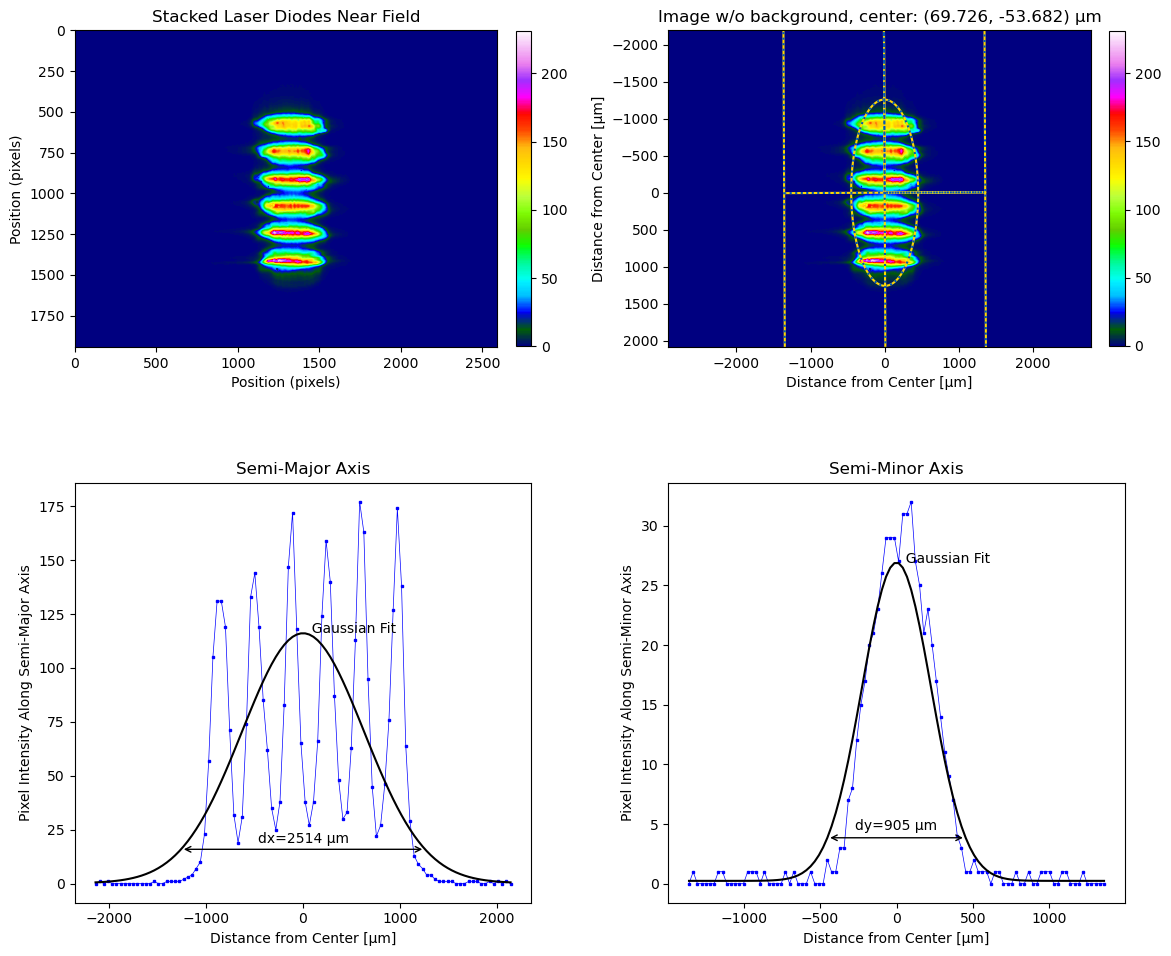

In [9]:
import sys
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Import from this directory so we can rapidly test
sys.path.append('../') # Needed for import
import laserbeamtools as lbs

def load_img(file, folder = r'../tests/test_beam_profiles/DAS'):
    """ Load an image into an array """
    full_path = folder + '/' + file
    if os.path.isfile(full_path):
        iobj = Image.open(full_path)
        img = np.asarray(iobj)
        return img
    else:
        print("No file found under:")
        print(full_path)
        return None

img = lbs.load_img('../tests/test_beam_profiles/DAS/nf_100_1234.bmp')

x, y, dx, dy, phi = lbs.beam_size(img)
print("The center of the beam ellipse is at (%.0f, %.0f)" % (x, y))
print("The ellipse diameter (closest to horizontal) is %.0f pixels" % dx)
print("The ellipse diameter (closest to   vertical) is %.0f pixels" % dy)
print("The ellipse is rotated %.0f° ccw from the horizontal" % (phi * 180/3.1416))

lbs.plot_image_analysis(img, pixel_size=2.2, title="Stacked Laser Diodes Near Field")
plt.show()

# Example Of Knife-Edging
---
The below figures show a knife edge measurement in a few discrete increments.

The fractional range is from `-3*dx` to `3*dx` (or `dy` depending on dir).

## Knife-Edging In Y Direction:

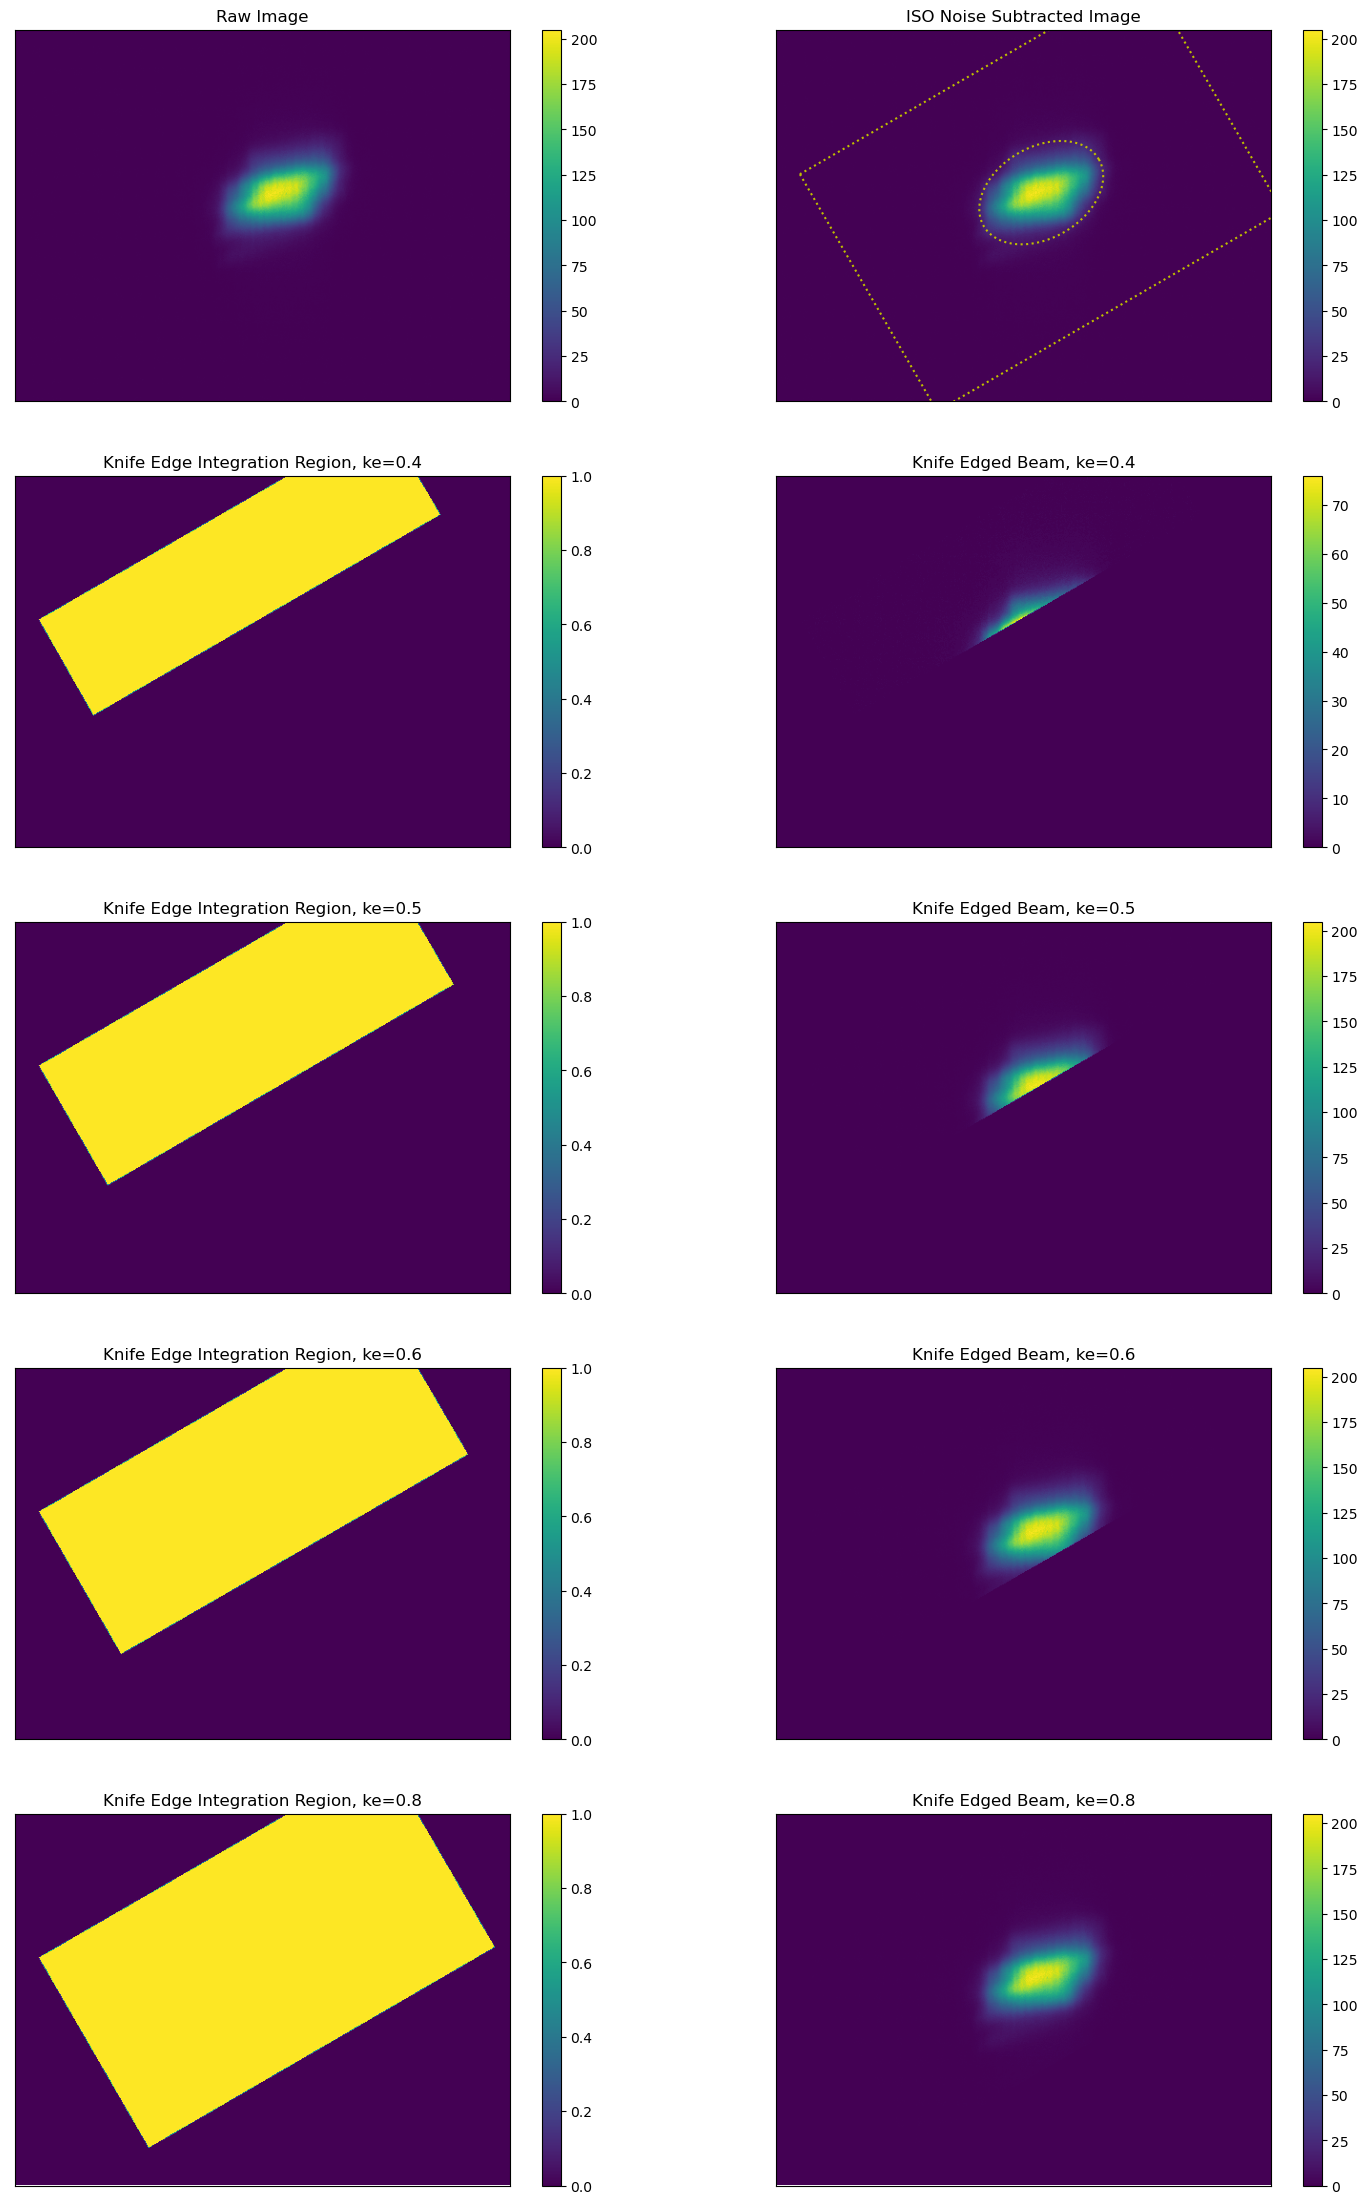

In [9]:

import numpy as np
import time

# Load image
img = lbs.load_img('../tests/test_beam_profiles/DAS/ff_100_1234.bmp')
crop_frac = 0.4
vv,hh = img.shape
vd = int(vv * crop_frac)
hd = int(hh * crop_frac)
img = img[vd:(vv-vd), hd:(hh-hd)]


# Parse Beam
x, y, dx, dy, phi = lbs.beam_size(img)

# Create subplots
plt.subplots(5,2,figsize=(18,28))

# Plot Raw Image
# -------------------------------------------------------------------------------------------- #

plt.subplot(5,2,1)
plt.imshow(img)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Raw Image')

# Plot ISO Noise Subtracted Image
# -------------------------------------------------------------------------------------------- #

# Create an image with a subtracted background
wimg = lbs.subtract_iso_background(img)

# Generate plots
plt.subplot(5,2,2)
plt.imshow(wimg)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('ISO Noise Subtracted Image')

# Plot masks
xp,yp = lbs.rotated_rect_arrays(x, y, dx, dy, phi)
plt.plot(xp,yp,':y')

xp,yp = lbs.ellipse_arrays(x, y, dx, dy, phi)
plt.plot(xp,yp,':y')

# Limit plot size
vv, hh = wimg.shape
plt.xlim(0, hh)
plt.ylim(vv, 0)

# Knife Edge ke = 0.25
# -------------------------------------------------------------------------------------------- #

def ke_plot(ke, i):
    """ Method to generate figures for knife edge images """

    plt.subplot(5,2,i)

    mask = lbs.knife_edge_mask(wimg, x, y, dx, dy, phi, ke, dir = 'y')

    plt.imshow(mask)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.title('Knife Edge Integration Region, ke={}'.format(ke))

    mwimg= np.copy(wimg)
    mwimg[mask < 1] = 0       # zero all values outside mask

    plt.subplot(5,2,i+1)
    plt.imshow(mwimg)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.title('Knife Edged Beam, ke={}'.format(ke))

# -------------------------------------------------------------------------------------------- #

# Generate knife edge figures
ke_plot(0.4, 3)
ke_plot(0.5, 5)
ke_plot(0.6, 7)
ke_plot(0.8, 9)

Took 5.106 seconds to run measurement with 200 points


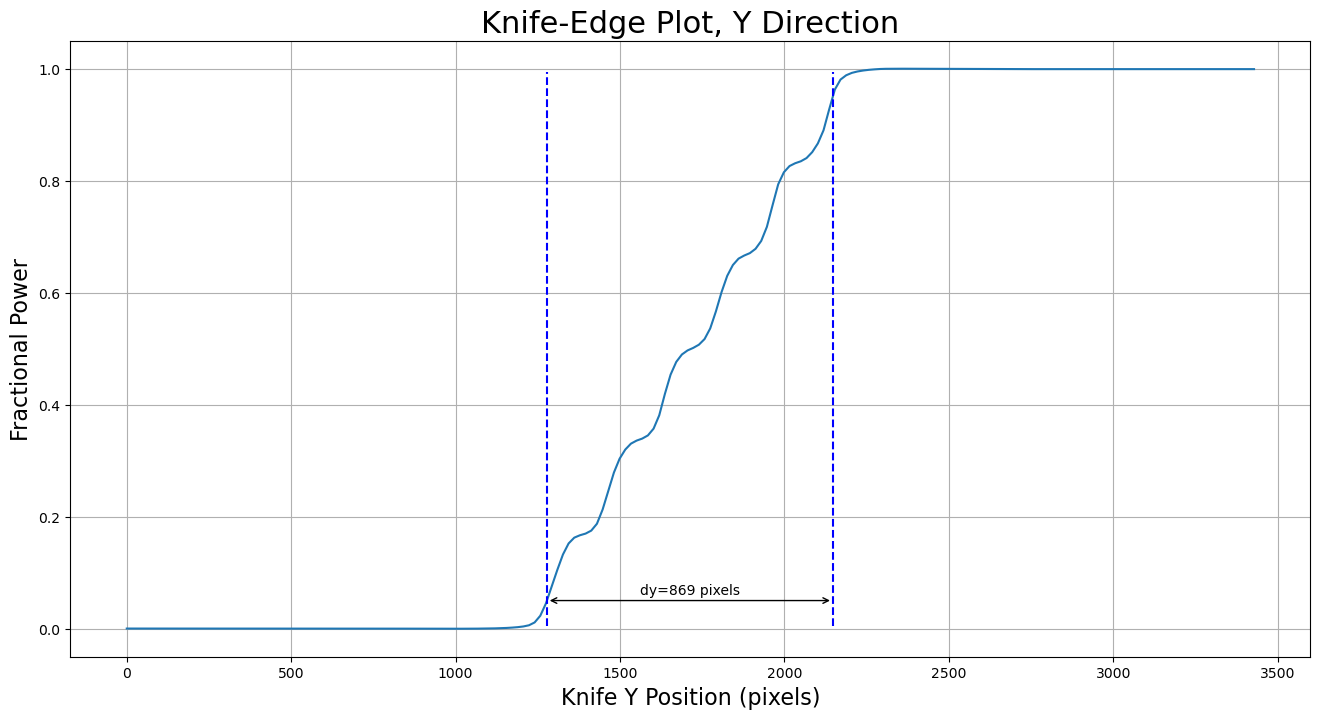

In [25]:
# Load image
img = lbs.load_img('../tests/test_beam_profiles/DAS/nf_100_1234.bmp')

# Subtract background
wimg = lbs.subtract_iso_background(img)

# Mask beam
mask = lbs.rotated_rect_mask(wimg, x, y, dx, dy, phi)

# Working image
mwimg = np.copy(wimg)

# Apply mask
mwimg[mask < 0] = 0

# Parse Beam
x, y, dx, dy, phi = lbs.beam_size(img)

# Create array
x_axis = np.linspace(0,1,200)
y_axis = np.full_like(x_axis, 0.0)

# Start time
time1 = time.time()

# Knife edge direction
dir = 'y'

# Collect knife-edge data
for i, x_val in enumerate(x_axis):
    mask = lbs.knife_edge_mask(mwimg, x, y, dx, dy, phi, x_val, dir = dir)
    masked_image = np.copy(mwimg)
    masked_image[mask < 1] = 0
    y_axis[i] = np.sum(masked_image)

# Normalize knife edge
y_axis = y_axis/np.max(y_axis)

# End time
time2 = time.time()

# Plotting
# -------------------------------------------------------------------------------------------- #

# Convert x axis to pixels
x_axis_p = x_axis * dy * 3

plt.figure(2, figsize=(16,8))
plt.title("Knife-Edge Plot, Y Direction", fontsize = 22)
plt.xlabel("Knife Y Position (pixels)", fontsize=16)
plt.ylabel("Fractional Power", fontsize = 16)
plt.plot(x_axis_p, y_axis)
plt.grid('on')

# Print time information
print("Took {:.3f} seconds to run measurement with {} points".format(time2-time1, len(x_axis)))

# Find beam width using 5-95 knife-edge measurement
ke1 = 0.05
ke2 = 0.95

# Interpolate values
bws = np.interp([ke1, ke2], y_axis, x_axis_p)

# Plot lines
plt.axvline(x=bws[0], ymin=0.05, ymax=0.95, color='b', label='{:.0f}% Point'.format(ke1*100), ls='--')
plt.axvline(x=bws[1], ymin=0.05, ymax=0.95, color='b', label='{:.0f}% Point'.format(ke2*100), ls='--')

# Show distance on plot
units = 'pixels'
plt.annotate('', (bws[0], ke1), (bws[1], ke1), arrowprops={'arrowstyle': '<->'})
plt.text(np.average(bws), 1.1 * ke1, 'd%s=%.0f %s' % (dir, bws[1]-bws[0], units), va='bottom', ha='center')

# Show plots
plt.show()

# Rotated Knife-Edge Plots

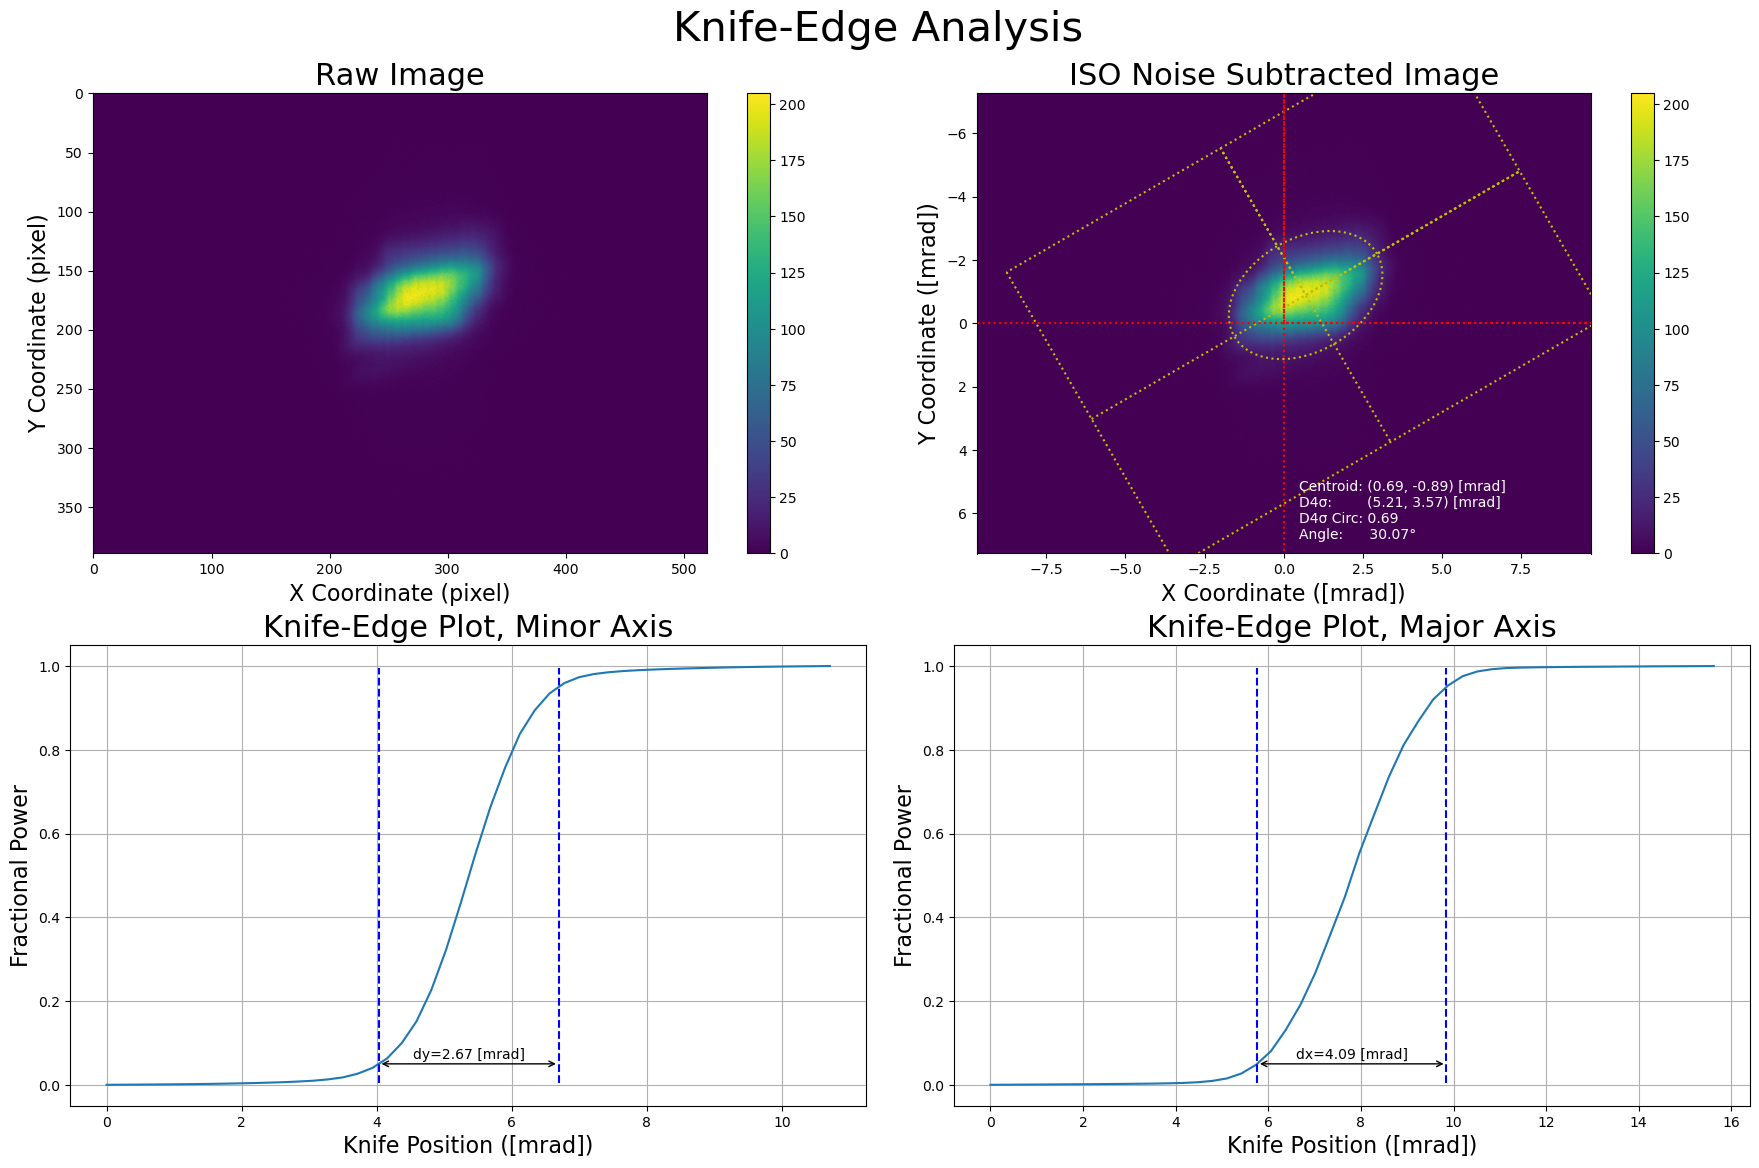

In [12]:
# Input image
img = lbs.load_img('../tests/test_beam_profiles/DAS/ff_100_1234.bmp')
crop_frac = 0.4
vv,hh = img.shape
vd = int(vv * crop_frac)
hd = int(hh * crop_frac)
img = img[vd:(vv-vd), hd:(hh-hd)]

lbs.plot_knife_edge_analysis_slow(img, pixel_size= 2.2/59, units='mrad')

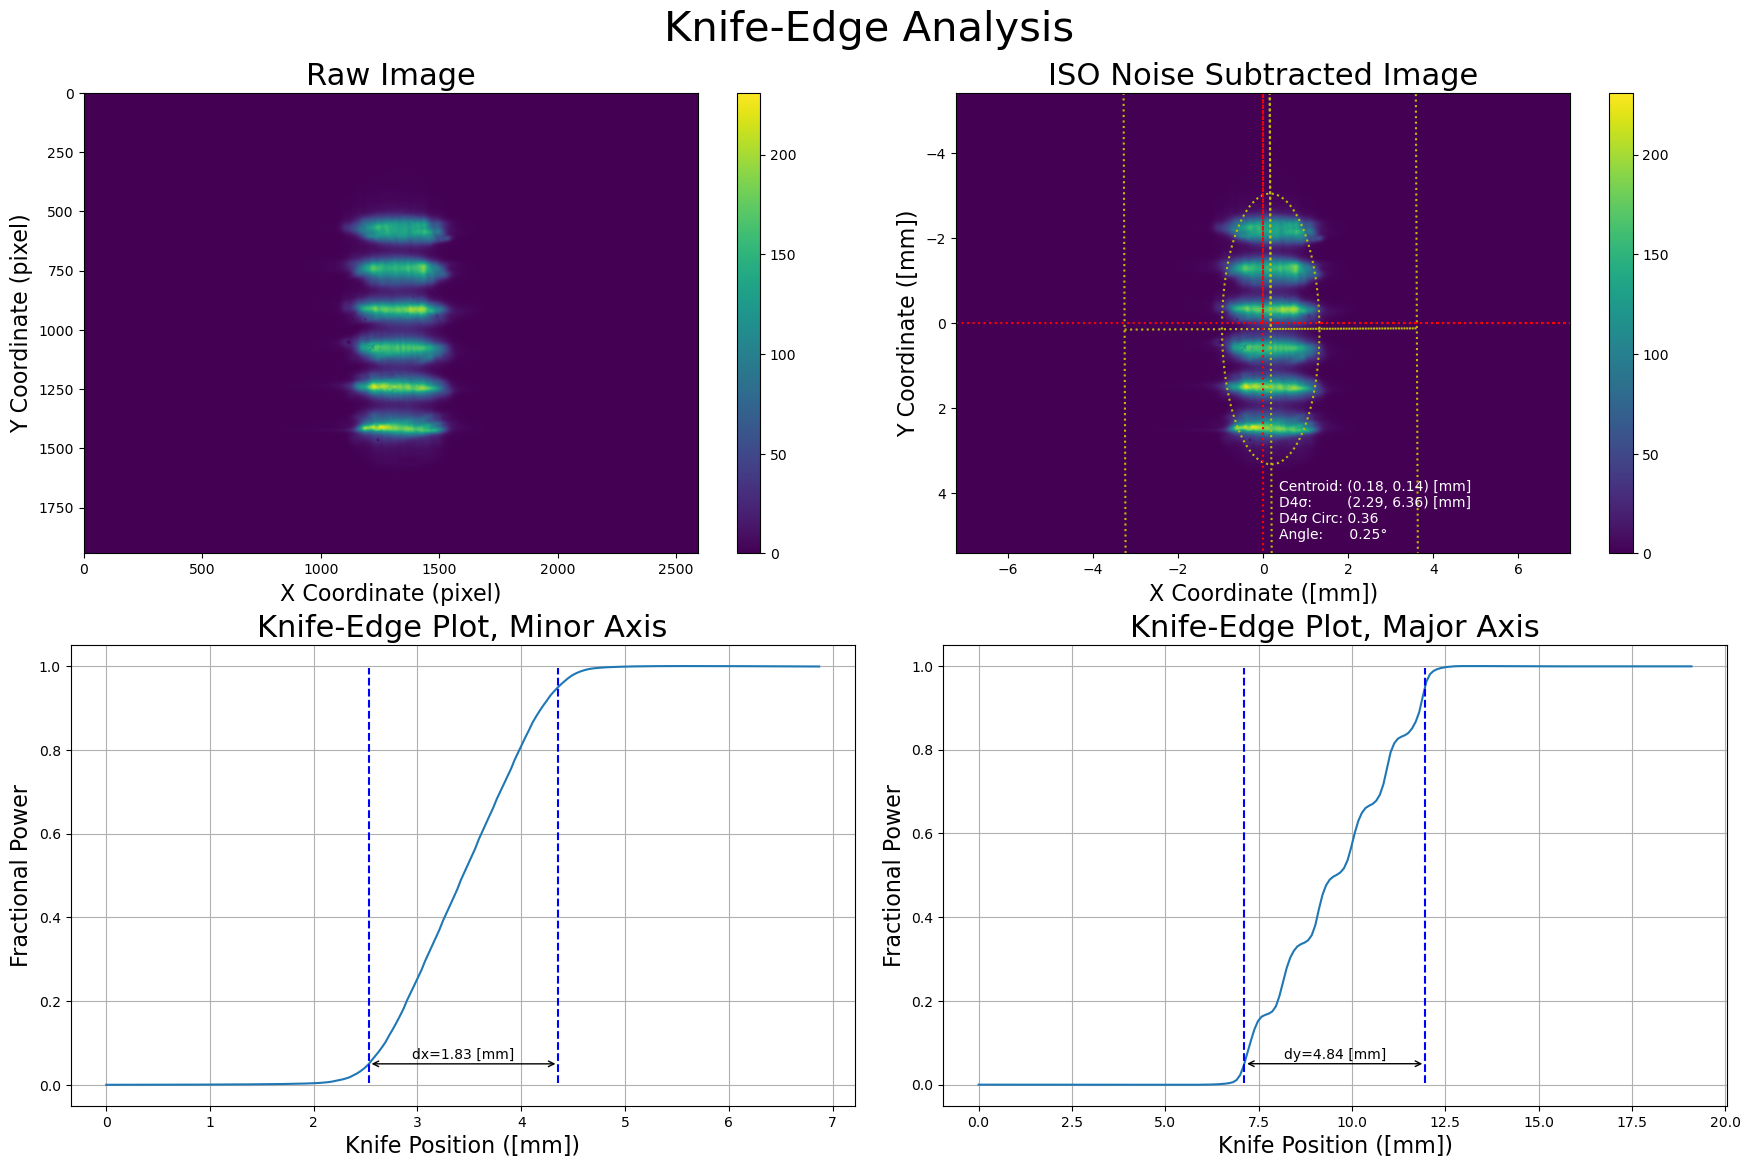

In [13]:
img = lbs.load_img('../tests/test_beam_profiles/DAS/nf_100_1234.bmp')
lbs.plot_knife_edge_analysis_slow(img, pixel_size=2.2 / 0.395 / 1000, units='mm', points=200)

# Failed Calculation
---
Calculation can fail if beam is small compared to the detector; however, this can often just be fixed by cropping the beam before inputing into the method.

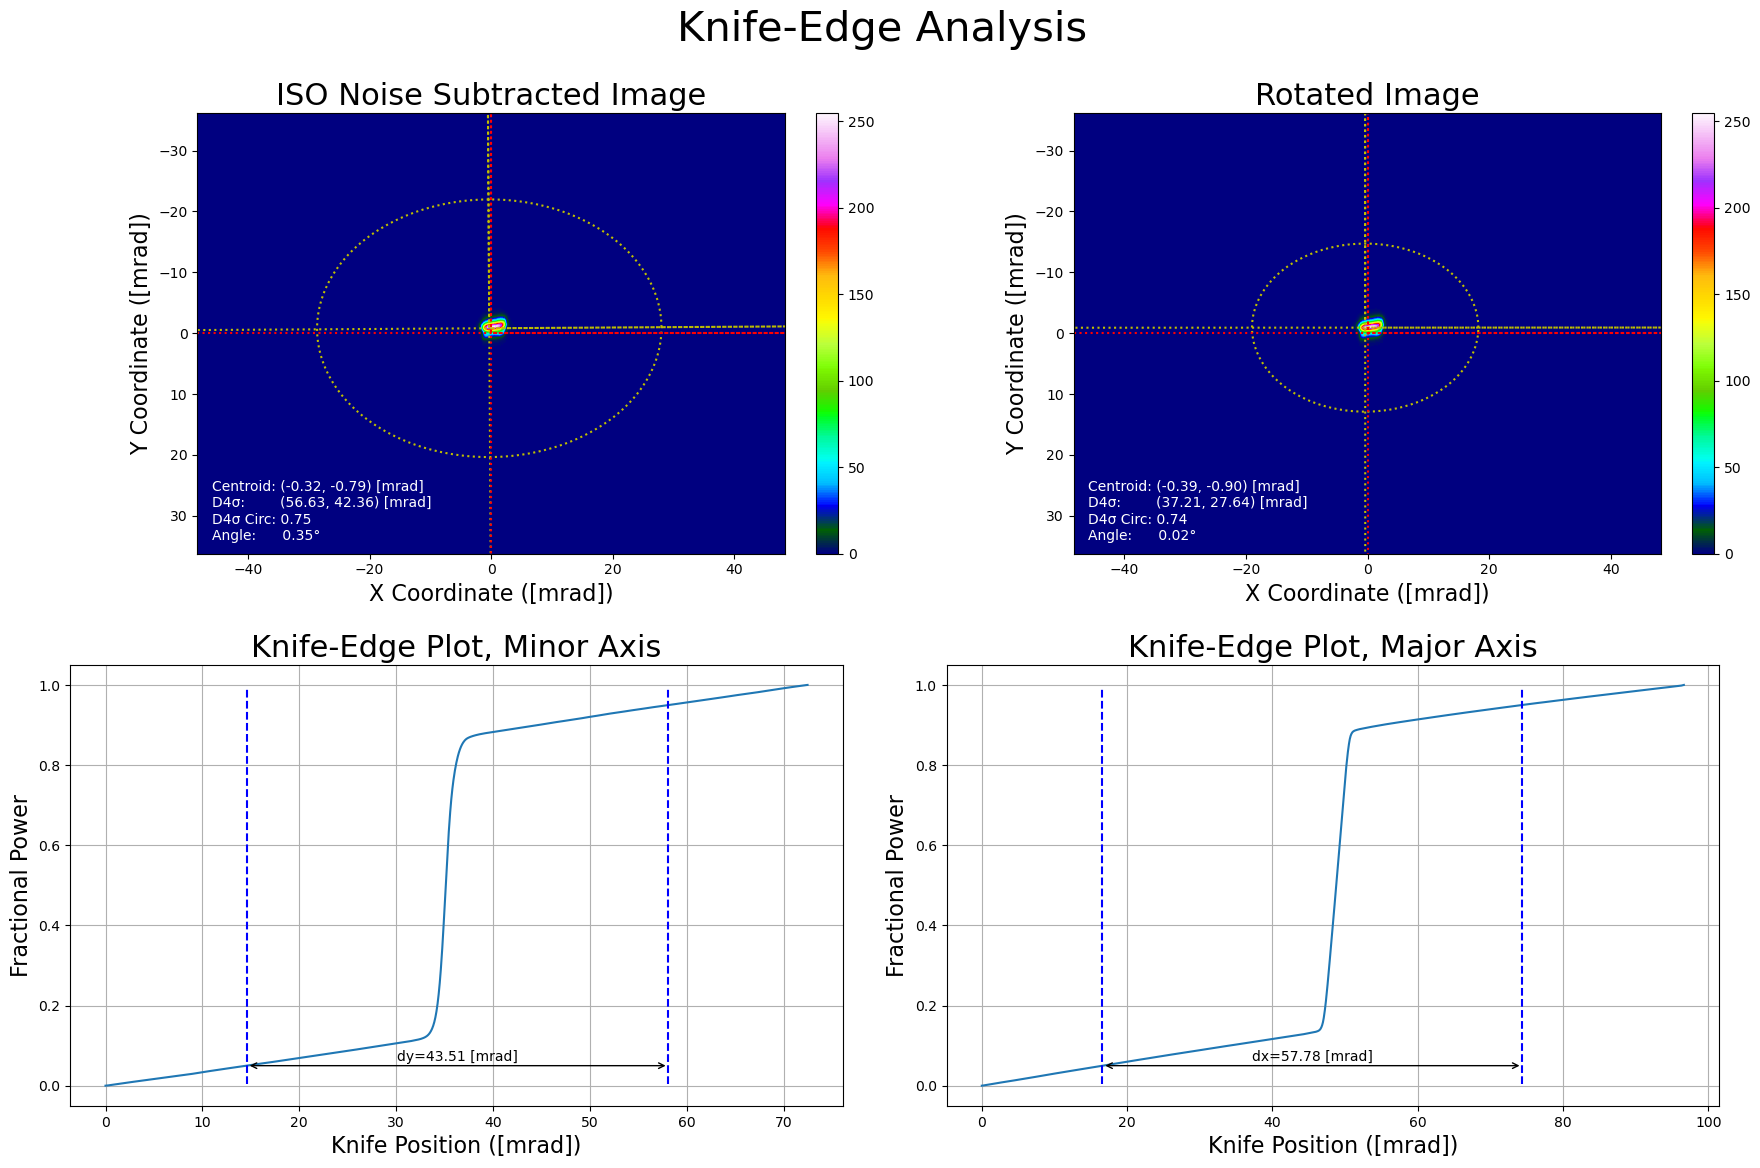

In [14]:
img = lbs.load_img('../tests/test_beam_profiles/DAS/check_img.bmp')
lbs.plot_knife_edge_analysis(img, pixel_size=2.2/59,units='mrad', points=200)

# Example Of Image Cropping
---
Here it's demonstrated that simply by cropping the previous image, we can return a succesful calculation.

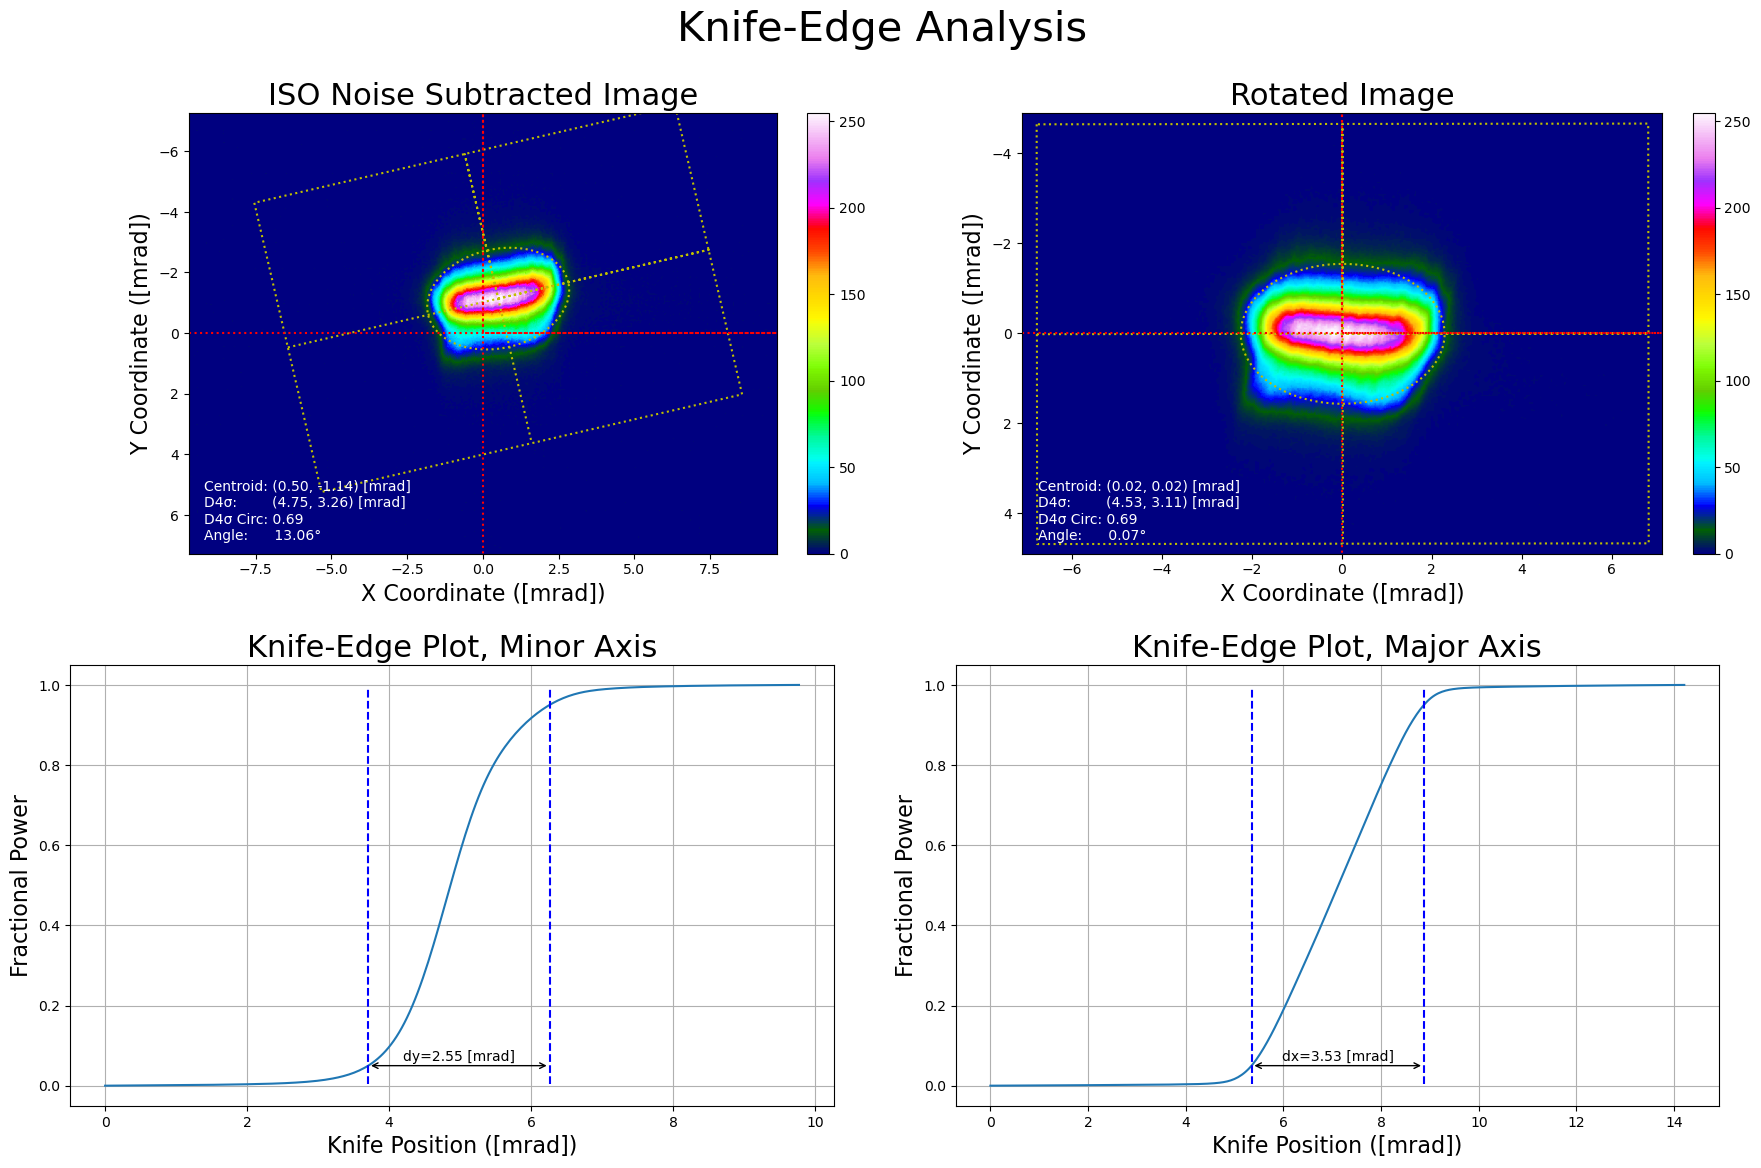

In [15]:
img = lbs.load_img('../tests/test_beam_profiles/DAS/check_img.bmp')
crop_frac = 0.4
vv,hh = img.shape
vd = int(vv * crop_frac)
hd = int(hh * crop_frac)
img = img[vd:(vv-vd), hd:(hh-hd)]

lbs.plot_knife_edge_analysis(img, pixel_size=2.2/59,units='mrad', points=200)

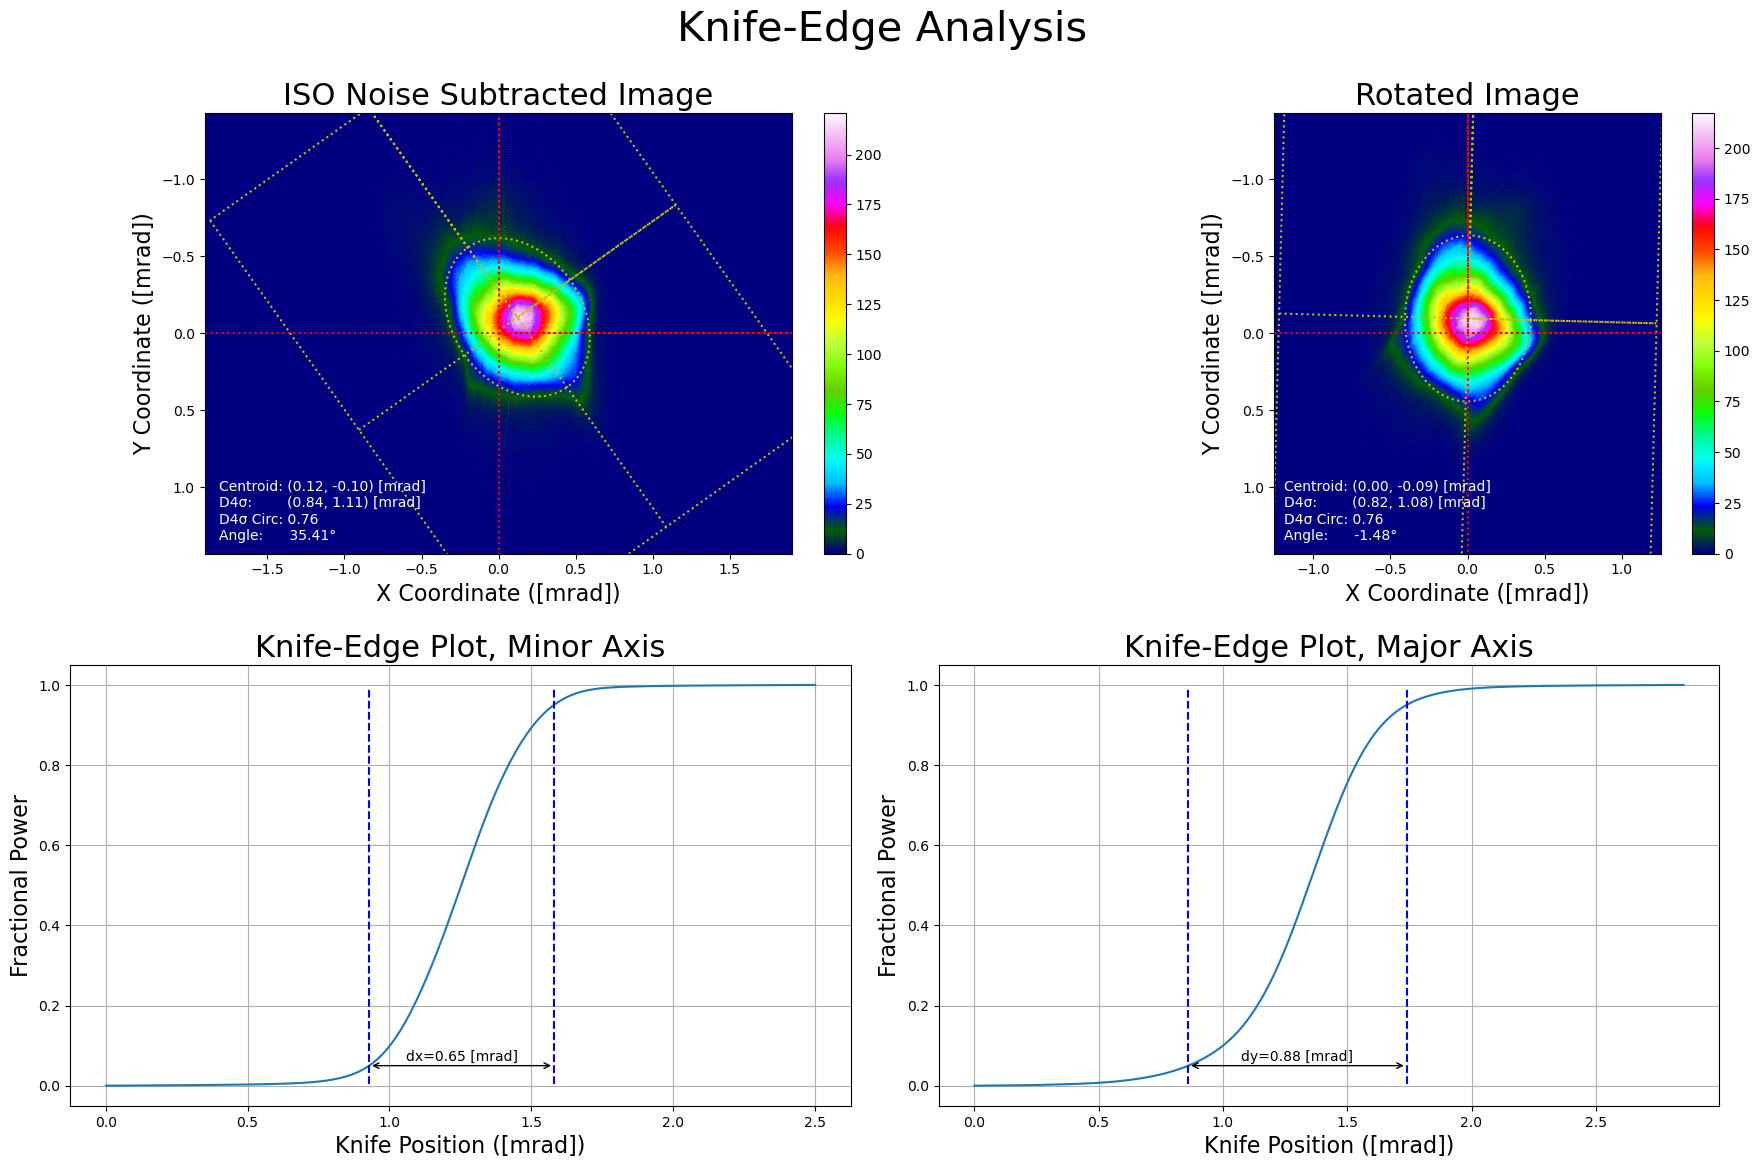

In [16]:
img = lbs.load_img('../tests/test_beam_profiles/BES/COL3/BE_All_FF.bmp')
crop_frac = 0.4
vv,hh = img.shape
vd = int(vv * crop_frac)
hd = int(hh * crop_frac)
img = img[vd:(vv-vd), hd:(hh-hd)]

lbs.plot_knife_edge_analysis(img, pixel_size=2.2/300,units='mrad', points=200)

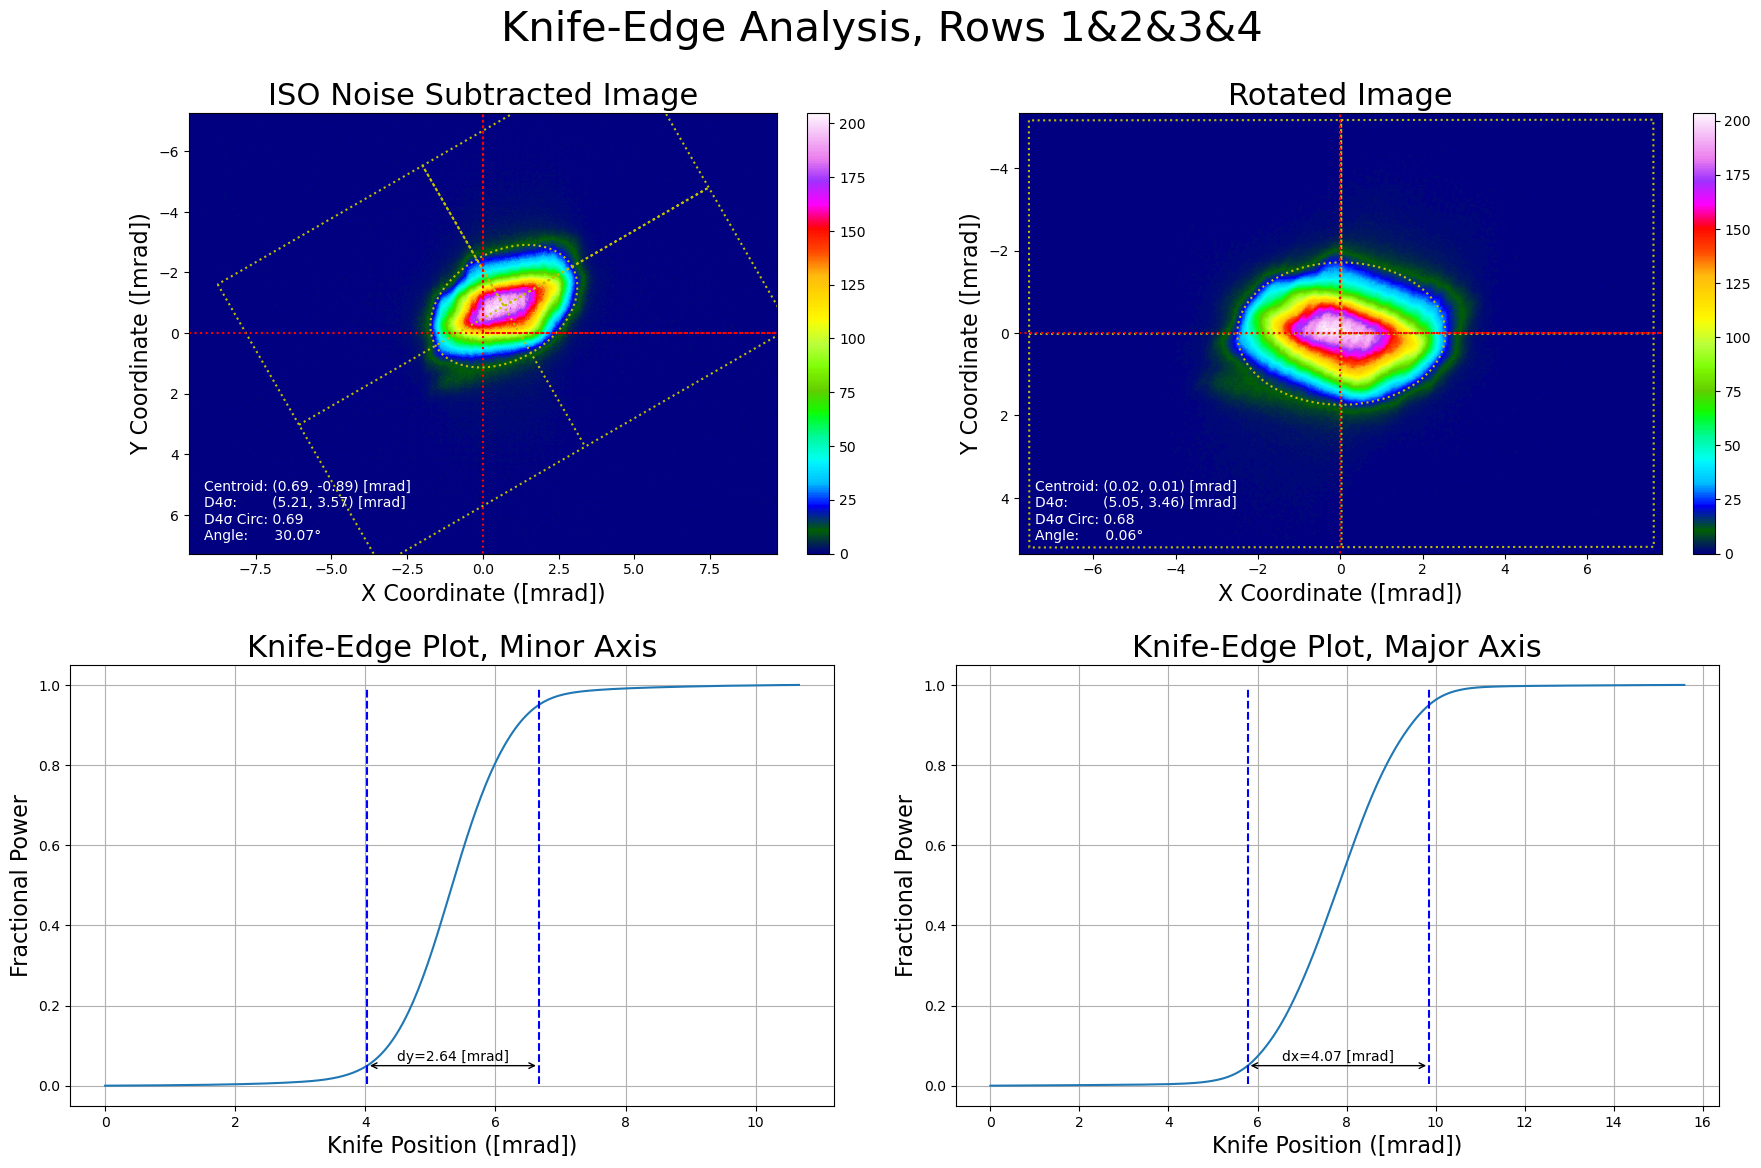

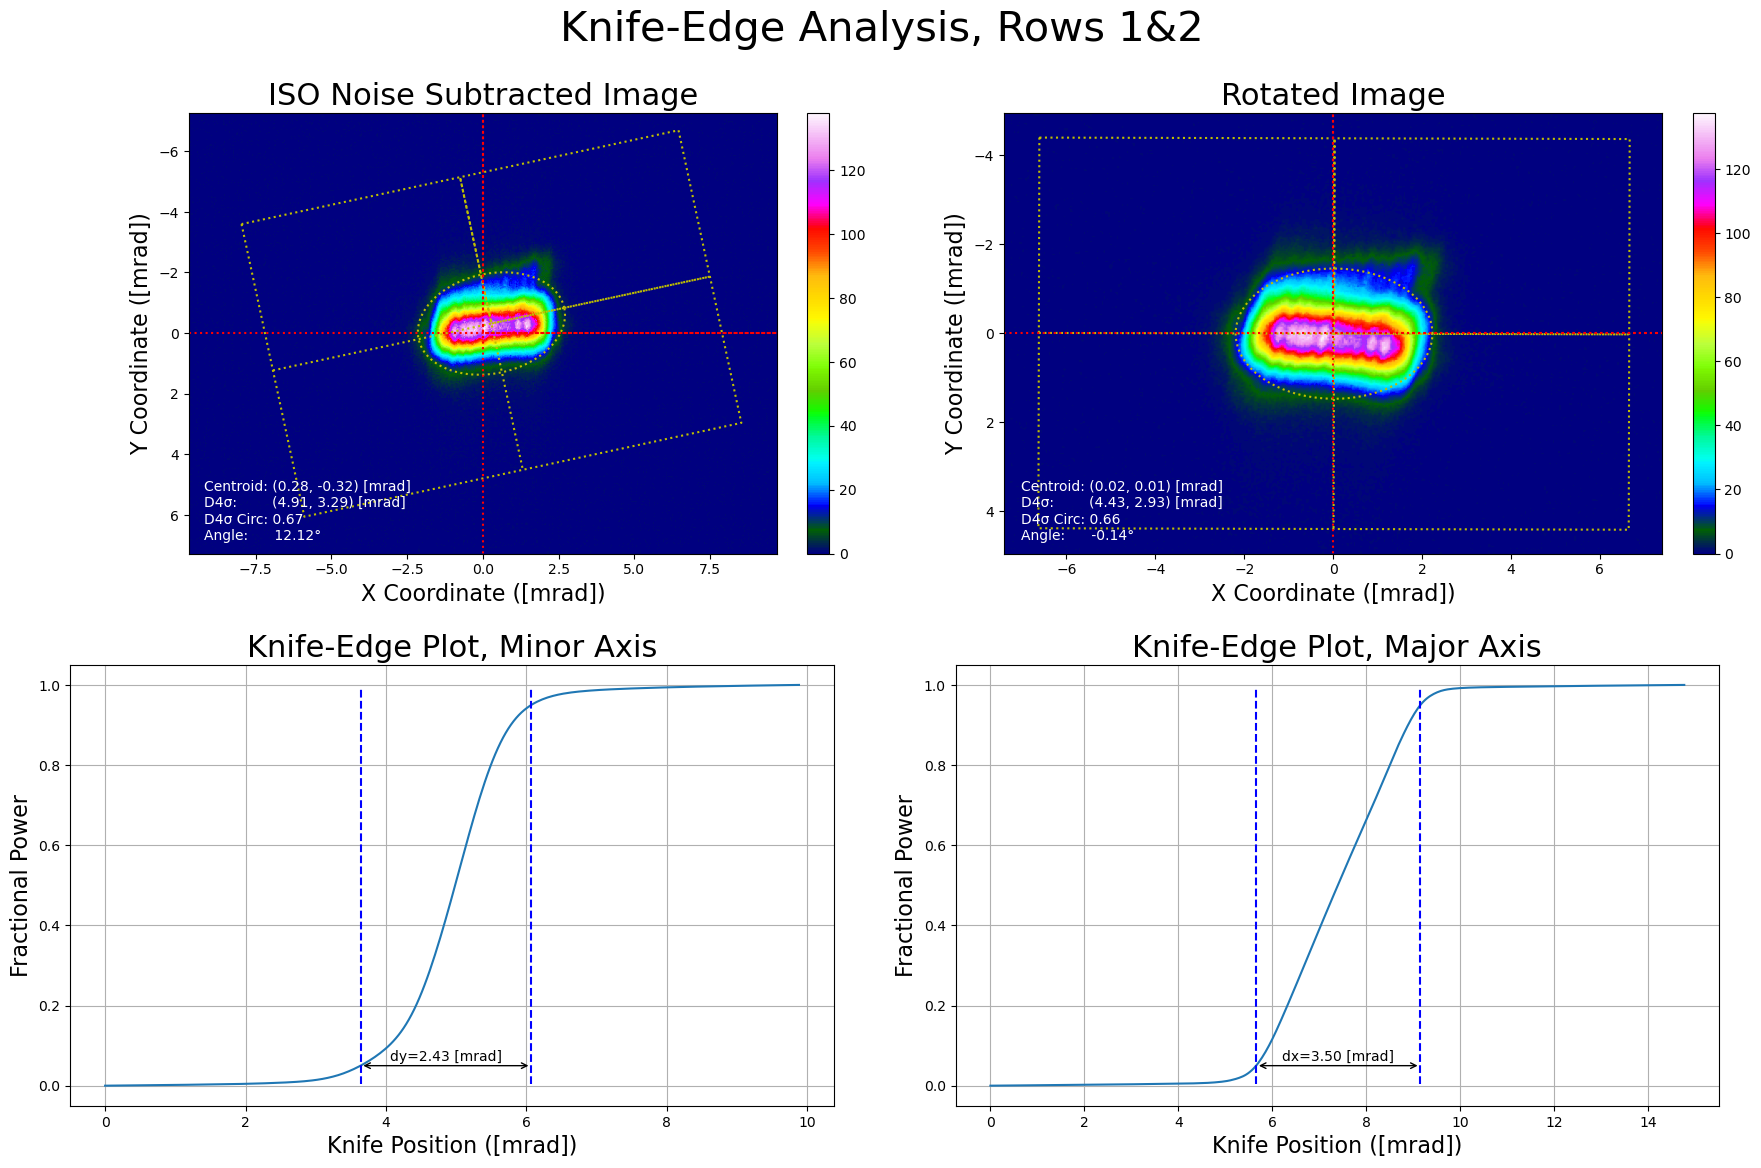

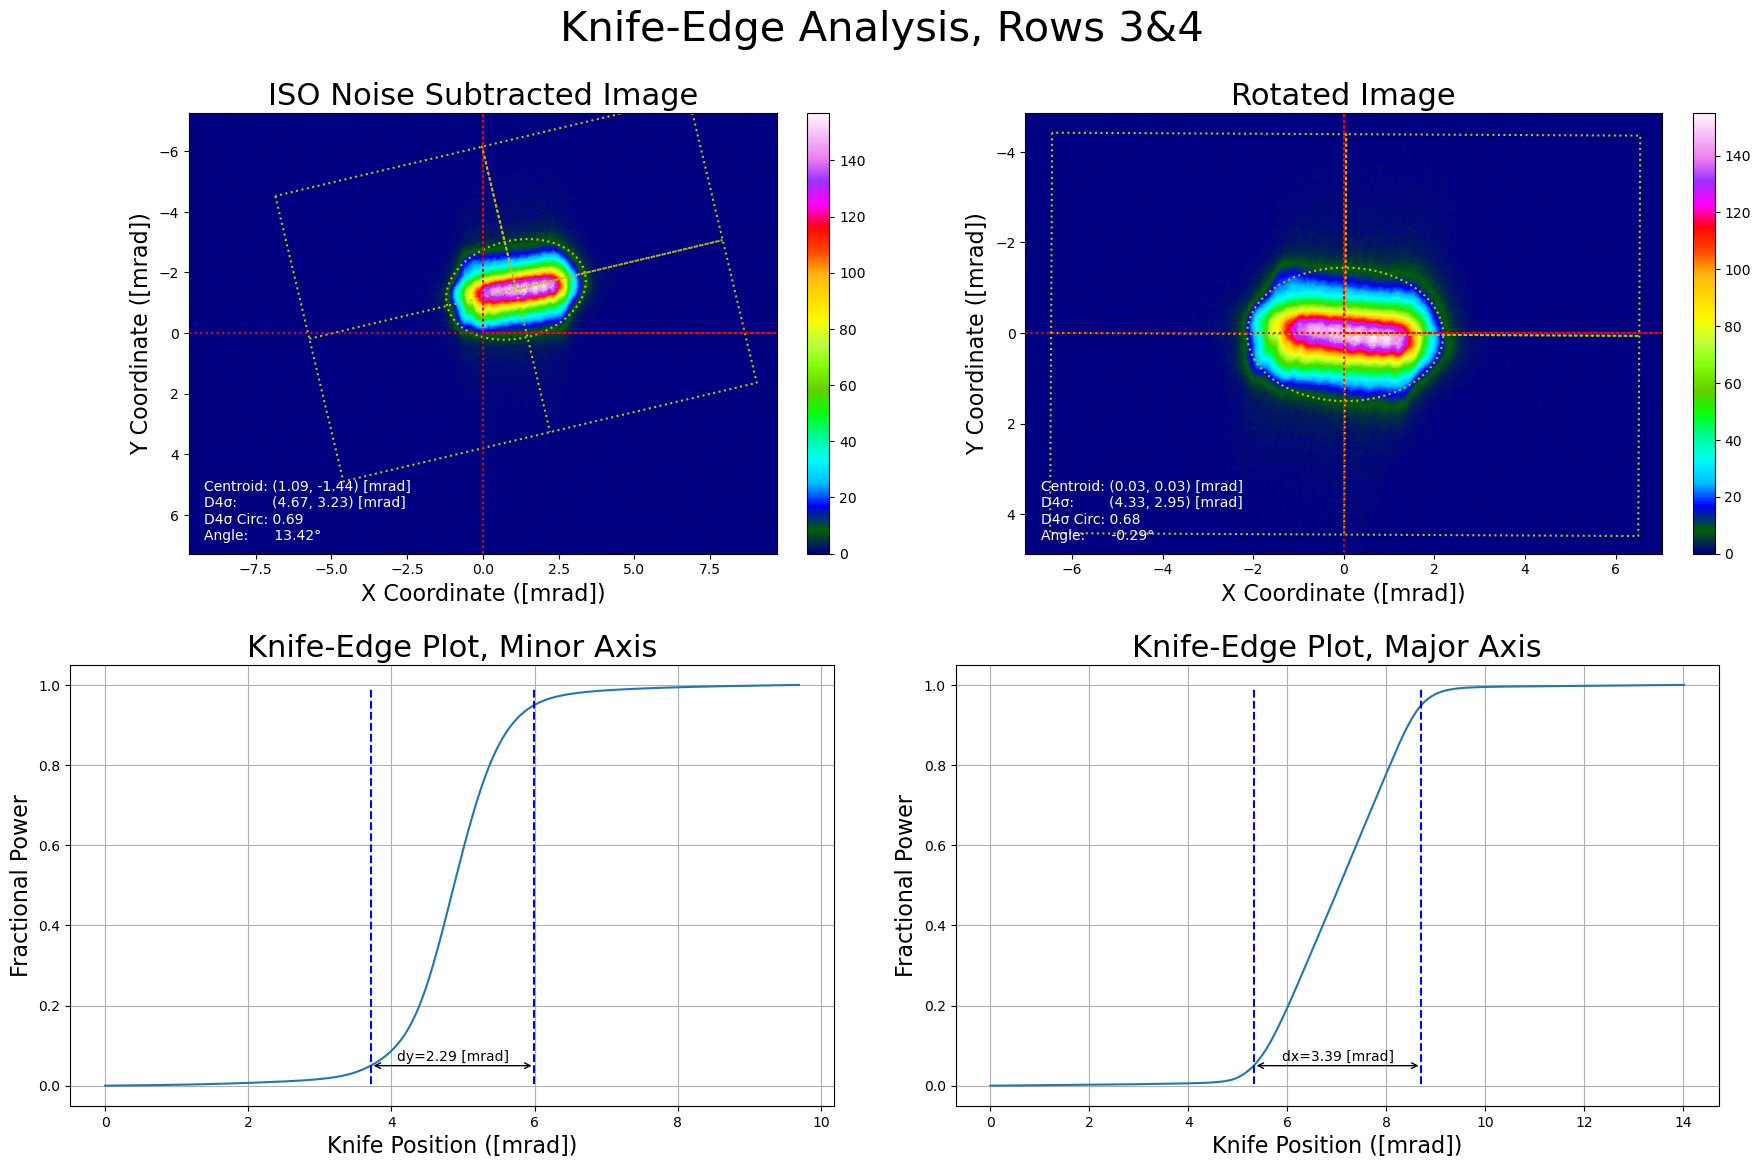

In [18]:
img = lbs.load_img('../tests/test_beam_profiles/DAS/ff_100_1234.bmp')

# Input image
crop_frac = 0.4
vv,hh = img.shape
vd = int(vv * crop_frac)
hd = int(hh * crop_frac)
img = img[vd:(vv-vd), hd:(hh-hd)]

lbs.plot_knife_edge_analysis(img, pixel_size= 2.2/59, units='mrad', title='Knife-Edge Analysis, Rows 1&2&3&4')

# Input image
img = lbs.load_img('../tests/test_beam_profiles/DAS/ff_100_12.bmp')
crop_frac = 0.4
vv,hh = img.shape
vd = int(vv * crop_frac)
hd = int(hh * crop_frac)
img = img[vd:(vv-vd), hd:(hh-hd)]

lbs.plot_knife_edge_analysis(img, pixel_size= 2.2/59, units='mrad', title='Knife-Edge Analysis, Rows 1&2')


# Input image
img = lbs.load_img('../tests/test_beam_profiles/DAS/ff_100_34.bmp')
crop_frac = 0.4
vv,hh = img.shape
vd = int(vv * crop_frac)
hd = int(hh * crop_frac)
img = img[vd:(vv-vd), hd:(hh-hd)]

lbs.plot_knife_edge_analysis(img, pixel_size= 2.2/59, units='mrad', title='Knife-Edge Analysis, Rows 3&4')

# Rotated Image Method For Knife Edge Measurement

beam_size time: 0.019
rotate_image time: 0.011


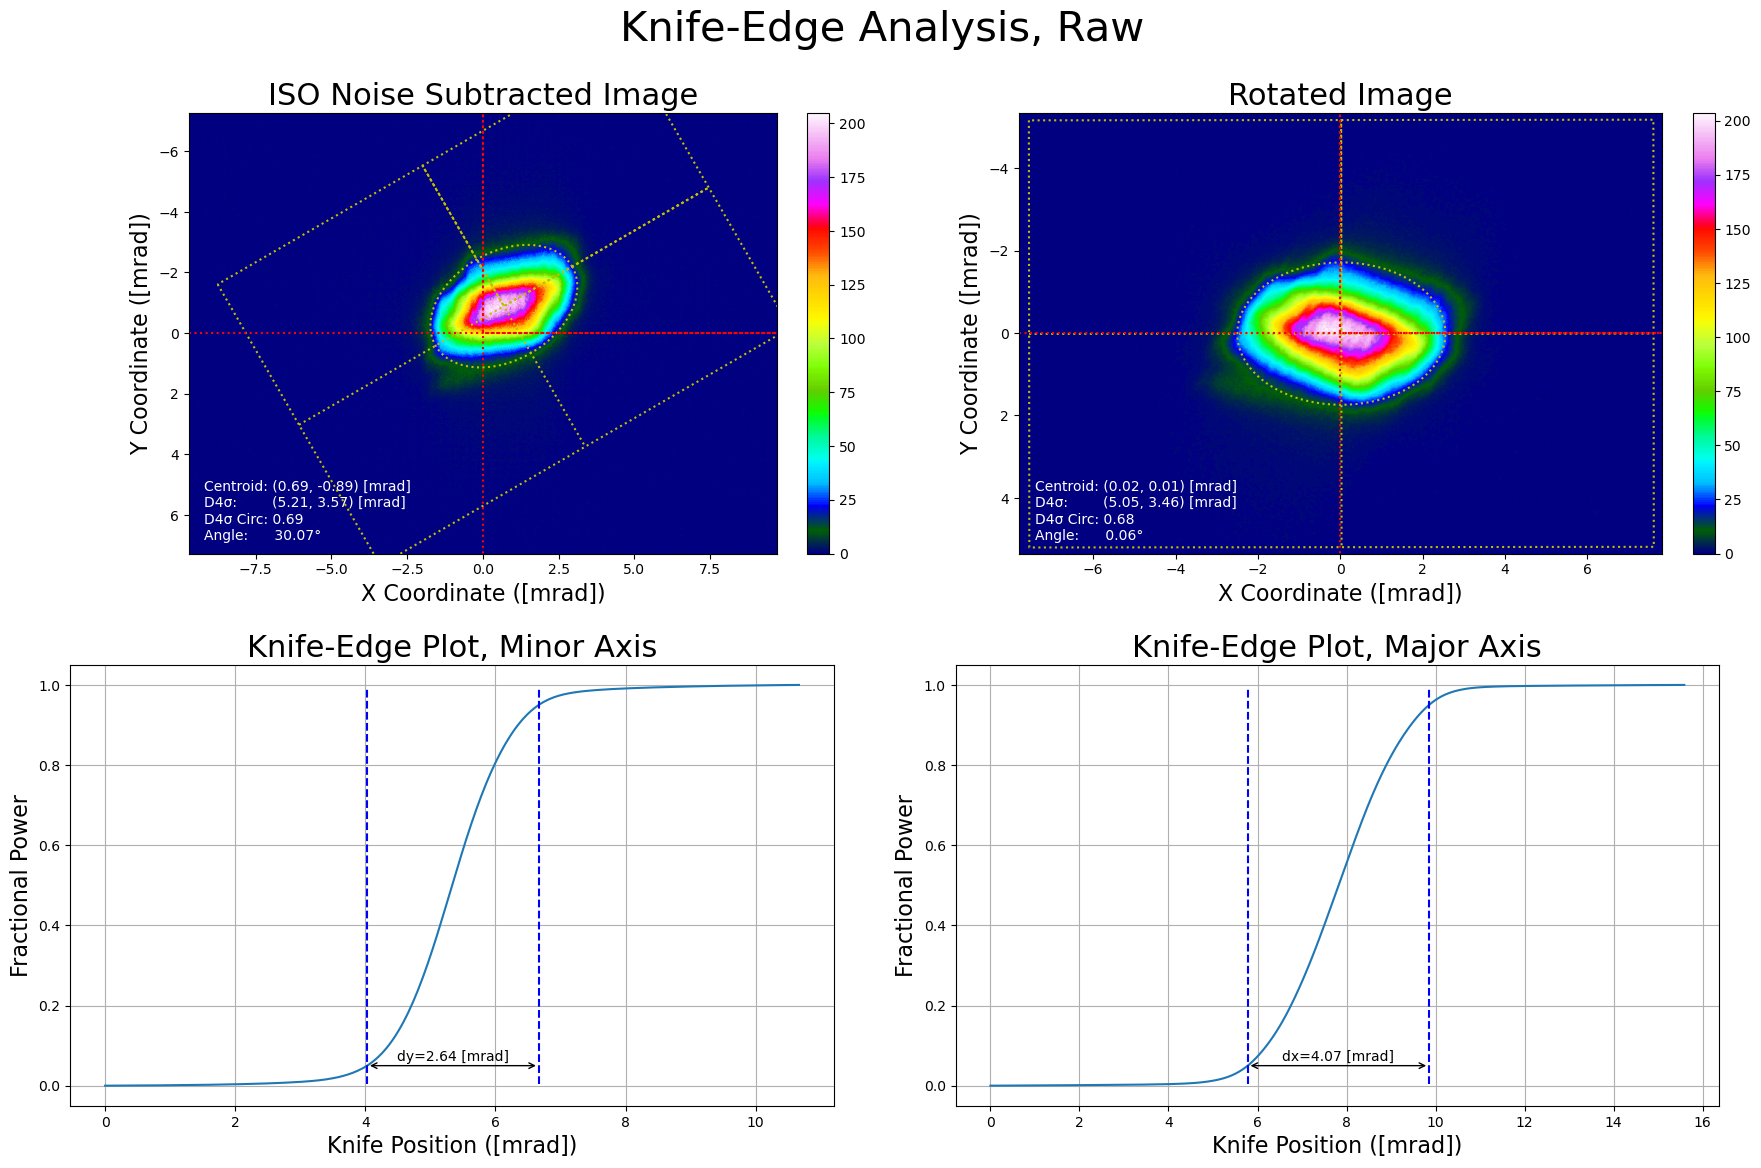

4.0526848837050675
2.624011774475461


In [19]:
img = lbs.load_img('../tests/test_beam_profiles/DAS/ff_100_1234.bmp')

# Input image
crop_frac = 0.4
vv,hh = img.shape
vd = int(vv * crop_frac)
hd = int(hh * crop_frac)
img = img[vd:(vv-vd), hd:(hh-hd)]

t1 = time.time()
x, y, dx, dy, phi = lbs.beam_size(img)
t2 = time.time()
print('beam_size time: %.3f' % (t2-t1))
img_r = lbs.rotate_image(img, x, y, -phi)
img_r, _, _  = lbs.crop_image_to_integration_rect(img_r, x, y, dx, dy, 0)
t3 = time.time()
print('rotate_image time: %.3f' % (t3-t2))

lbs.plot_knife_edge_analysis(img, pixel_size= 2.2/59, units='mrad', title='Knife-Edge Analysis, Raw')
# plot_knife_edge_analysis(img_r, pixel_size= 2.2/59, units='mrad', title='Knife-Edge Analysis, Rotated')

def ke(img, axis, kep = [0.05, 0.95]):
    """
    Knife Edge

    Arge:
        img: 2D array of image with beam spot in it
        axis: Direction to perform knife edge
        kep: knife edge points, i.e., 5%-95%
    Returns:
        y_cum: knife edge plot
        x: x axis in pixels
        points: knife edge point coords
    """
    # Sum along axis
    y = np.sum(img, axis=axis)
    
    # Cumulative sum
    y_cum = np.cumsum(y, axis=0)

    # Normalize
    y_cum = y_cum/np.max(y_cum)

    # Generate x axis
    x = np.linspace(0, len(y_cum), len(y_cum), endpoint = False)

    # Find points
    points = np.interp(kep, y_cum, x)
    return y_cum, x, points

xkex, _, xke = ke(img_r, 0)
ykex, _, yke = ke(img_r, 1)
m = 2.2/59
print((xke[1]-xke[0]) * m)
print((yke[1]-yke[0]) * m)


# Knife-Edge Fast

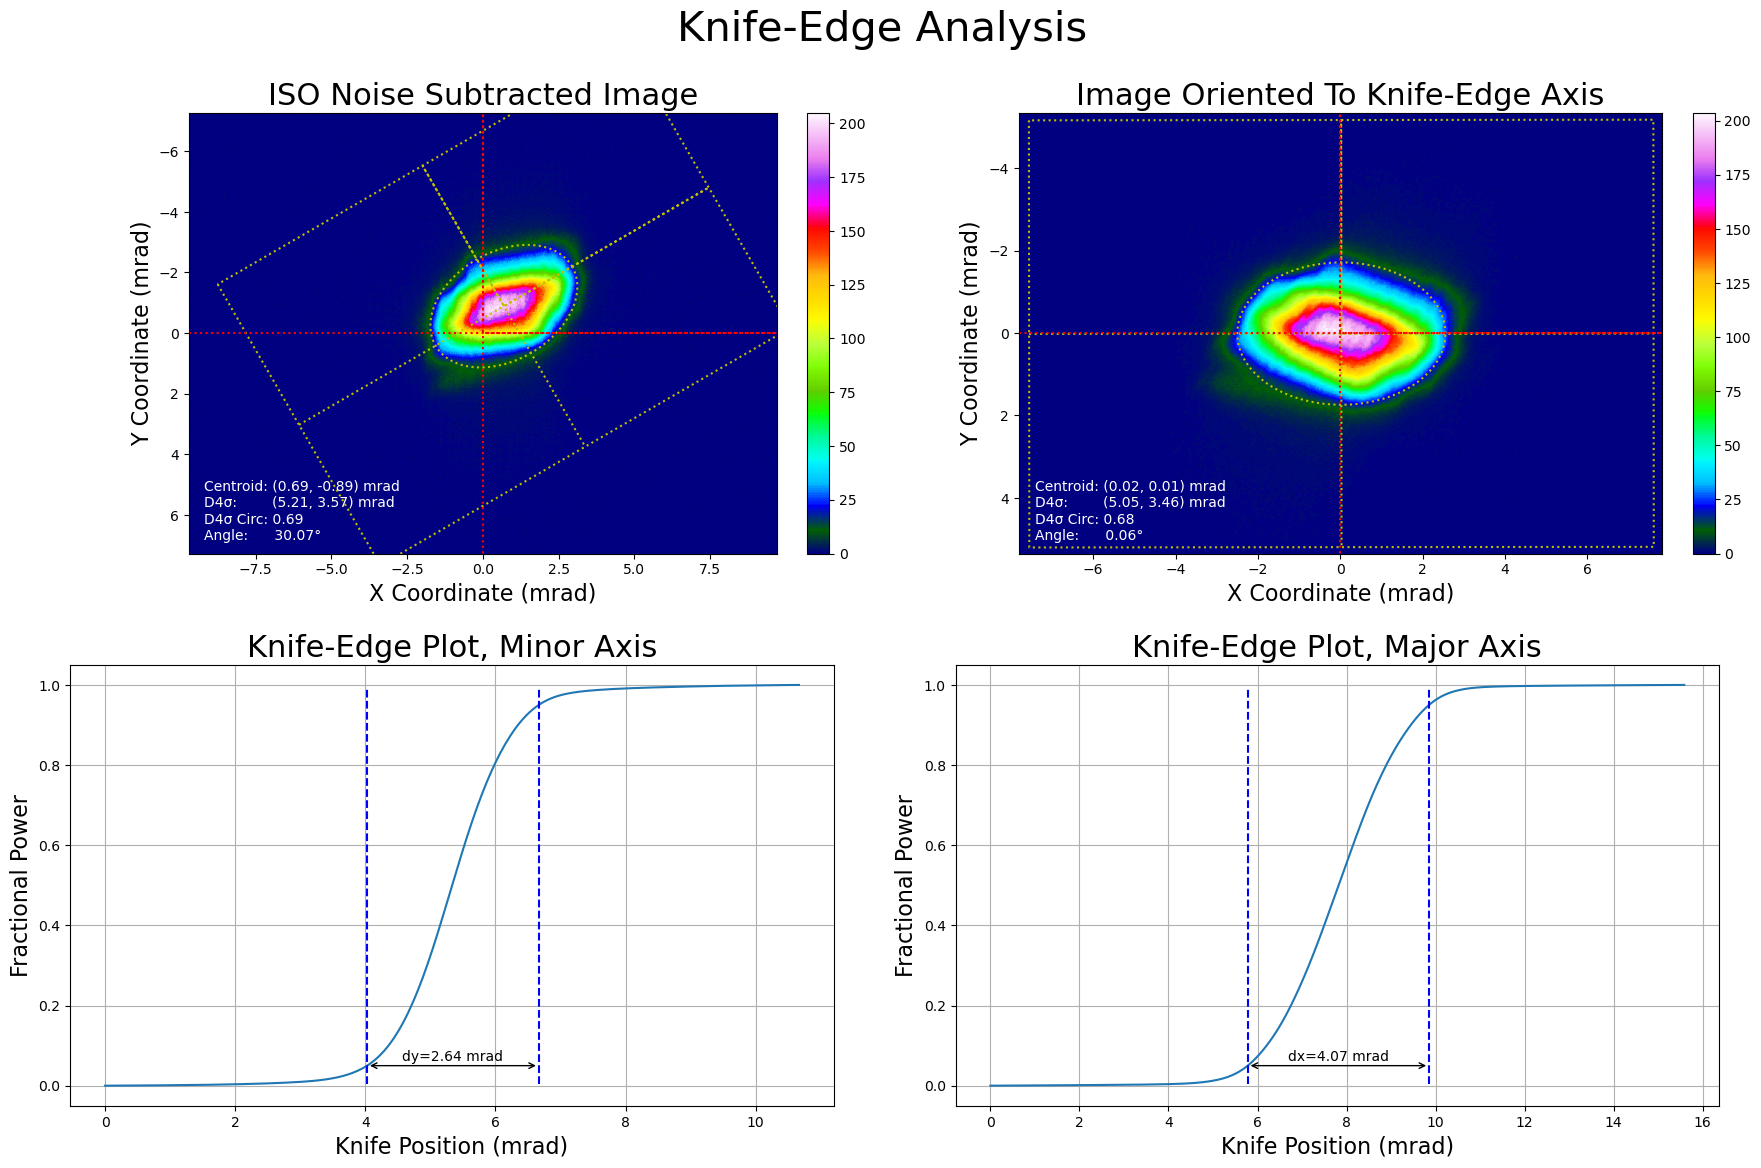

In [3]:
import sys
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Import from this directory so we can rapidly test
sys.path.append('../') # Needed for import
import laserbeamtools as lbs

img = lbs.load_img('../tests/test_beam_profiles/DAS/ff_100_1234.bmp')

# Input image
crop_frac = 0.4
vv,hh = img.shape
vd = int(vv * crop_frac)
hd = int(hh * crop_frac)
img = img[vd:(vv-vd), hd:(hh-hd)]

lbs.plot_knife_edge_analysis(img, pixel_size=2.2 / 59, units='mrad')

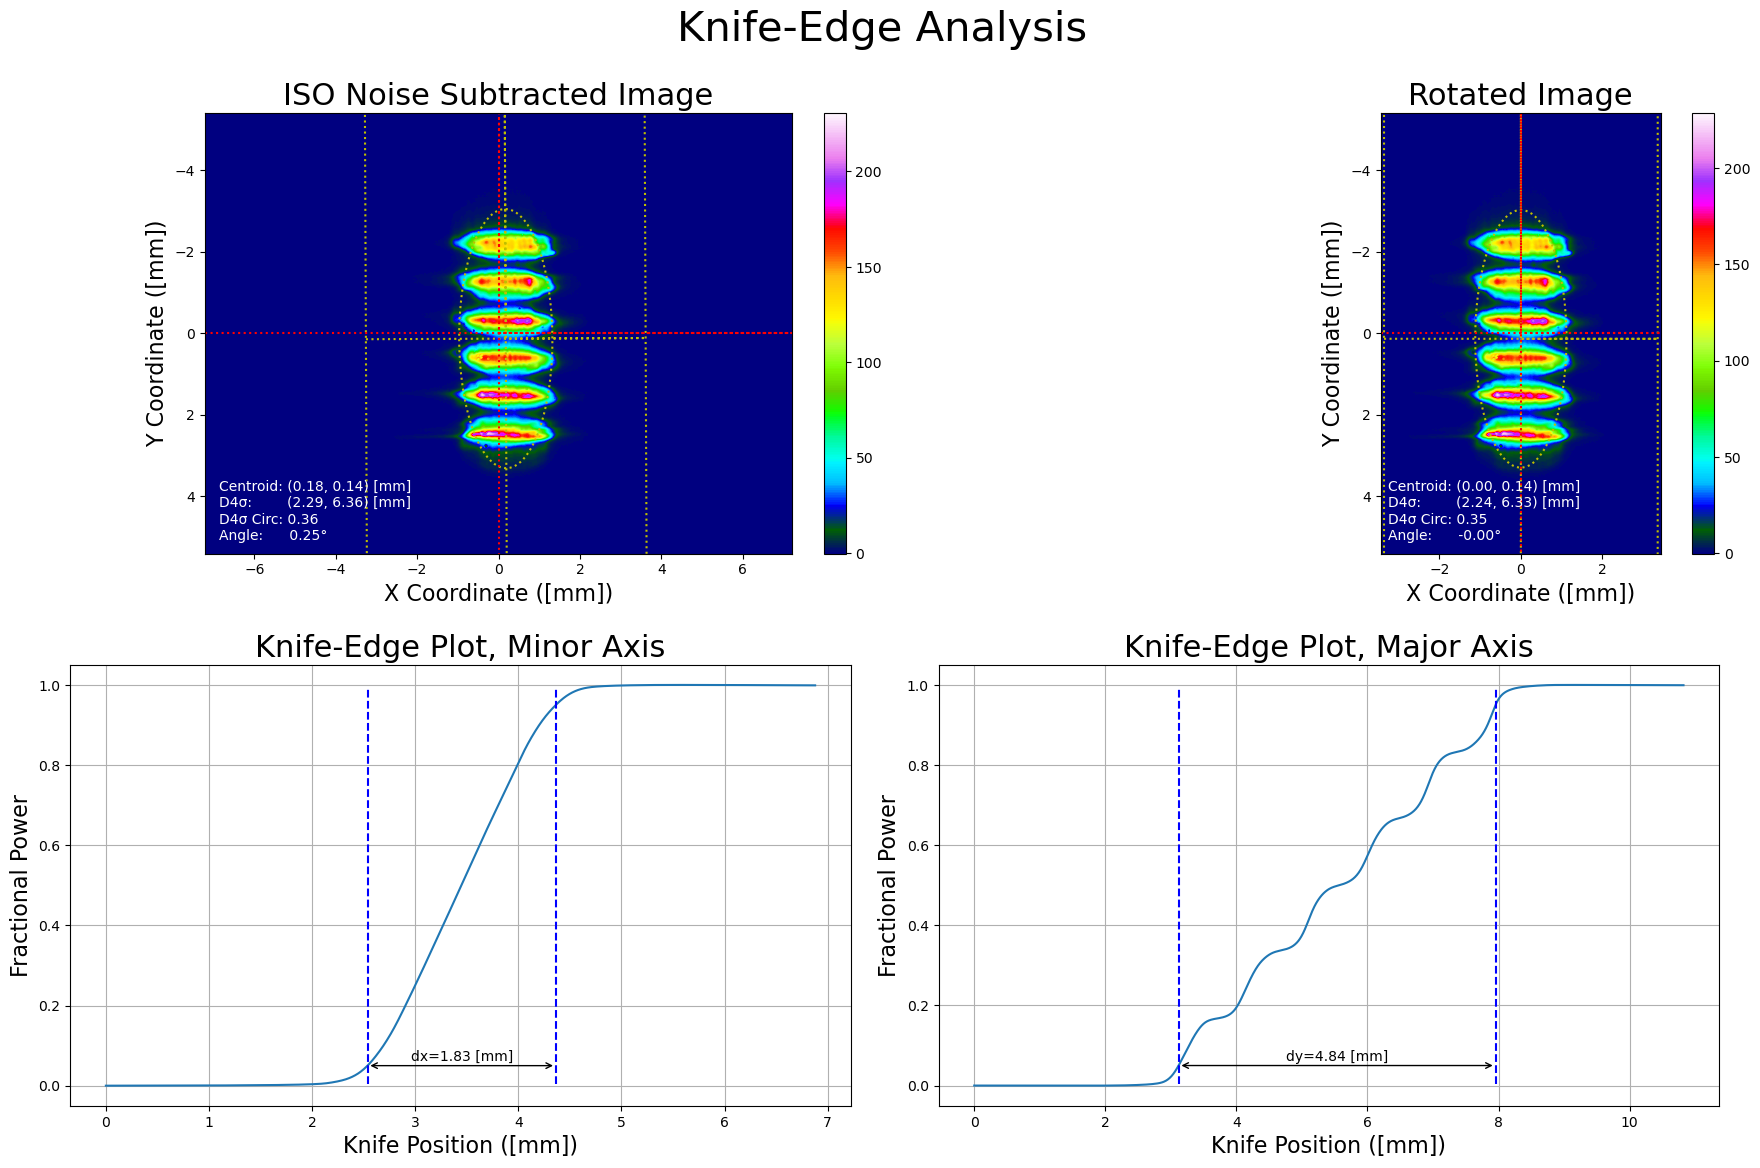

In [22]:
img = lbs.load_img(r'../tests/test_beam_profiles/DAS/' + 'nf_100_1234.bmp')
lbs.plot_knife_edge_analysis(img, pixel_size=2.2 / 0.395 / 1000, units='mm')

['100dc.txt', 'FF CW Row 1&2_0001.ascii.csv', 'FF CW Row 3&4_0001.ascii.csv', 'NF CW Row 1&2_0001.ascii.csv', 'NF CW Row 3&4_0001.ascii.csv']


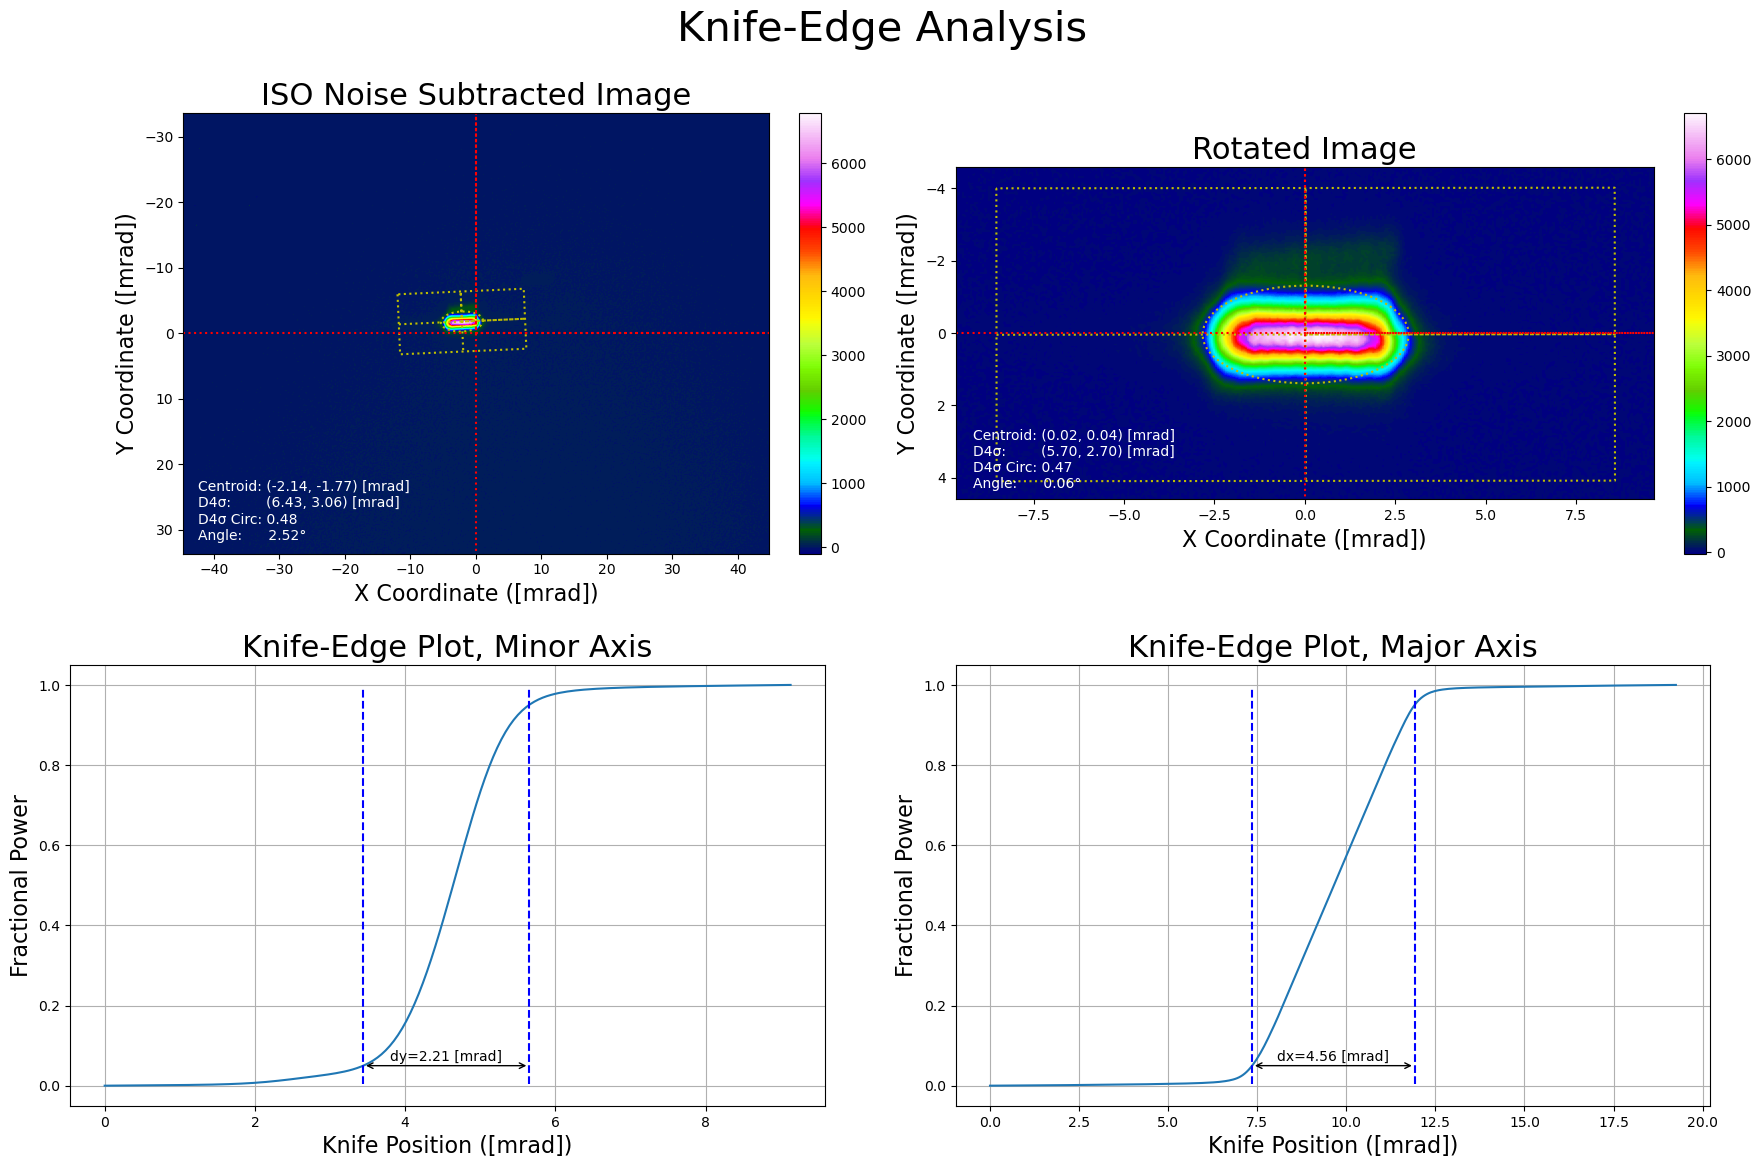

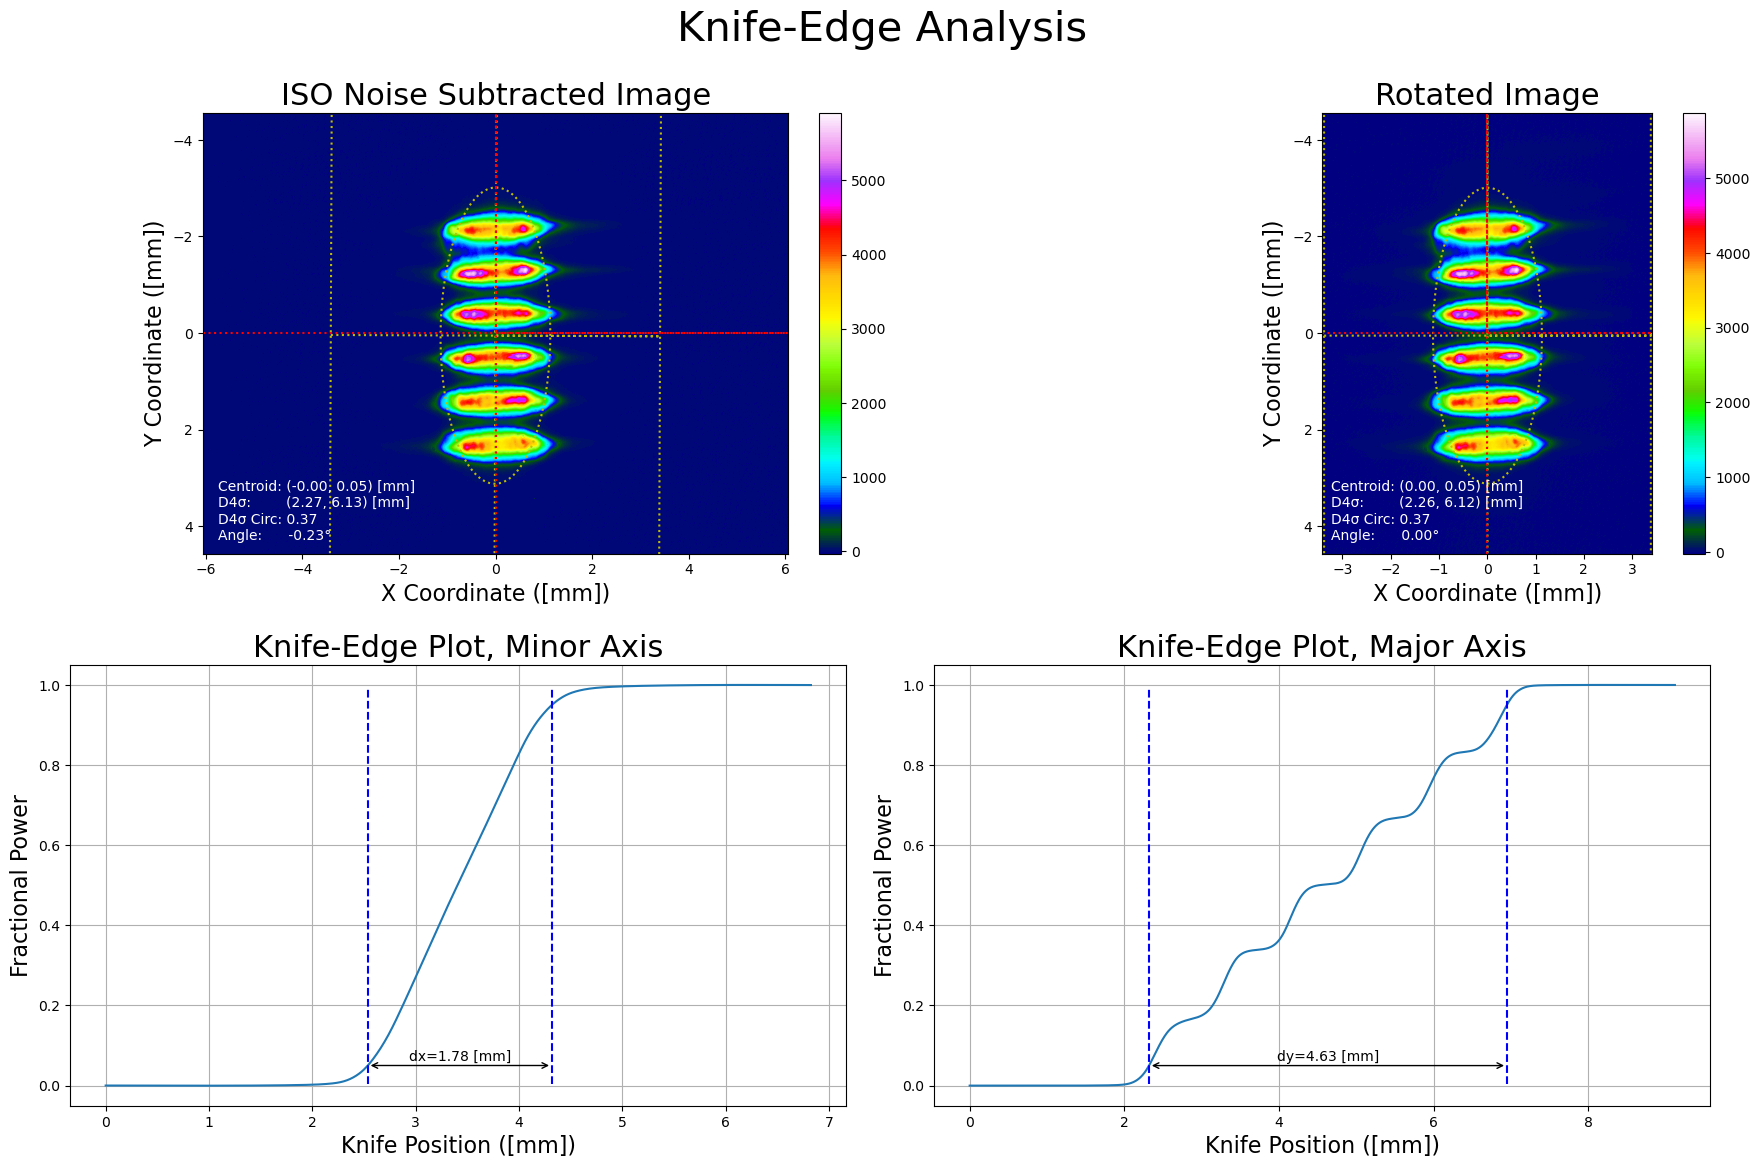

In [24]:
# Create a list of the files
folder = r'../tests/test_beam_profiles/For_Rayfile_Gen/22'

# Far field images
ff1_file = '/'.join([folder,r'FF CW Row 1&2_0001.ascii.csv'])
ff2_file = '/'.join([folder,r'FF CW Row 3&4_0001.ascii.csv'])

# Near field images
nf1_file = '/'.join([folder,r'NF CW Row 1&2_0001.ascii.csv'])
nf2_file = '/'.join([folder,r'NF CW Row 3&4_0001.ascii.csv'])

img1 = lbs.load_img(ff1_file)
img2 = lbs.load_img(ff2_file)
img=img1+img2

lbs.plot_knife_edge_analysis(img, pixel_size=4.4 / 80, units='mrad')

img1 = lbs.load_img(nf1_file)
img2 = lbs.load_img(nf2_file)
img=img1+img2

lbs.plot_knife_edge_analysis(img, pixel_size=4.4 / 0.59 / 1000, units='mm')

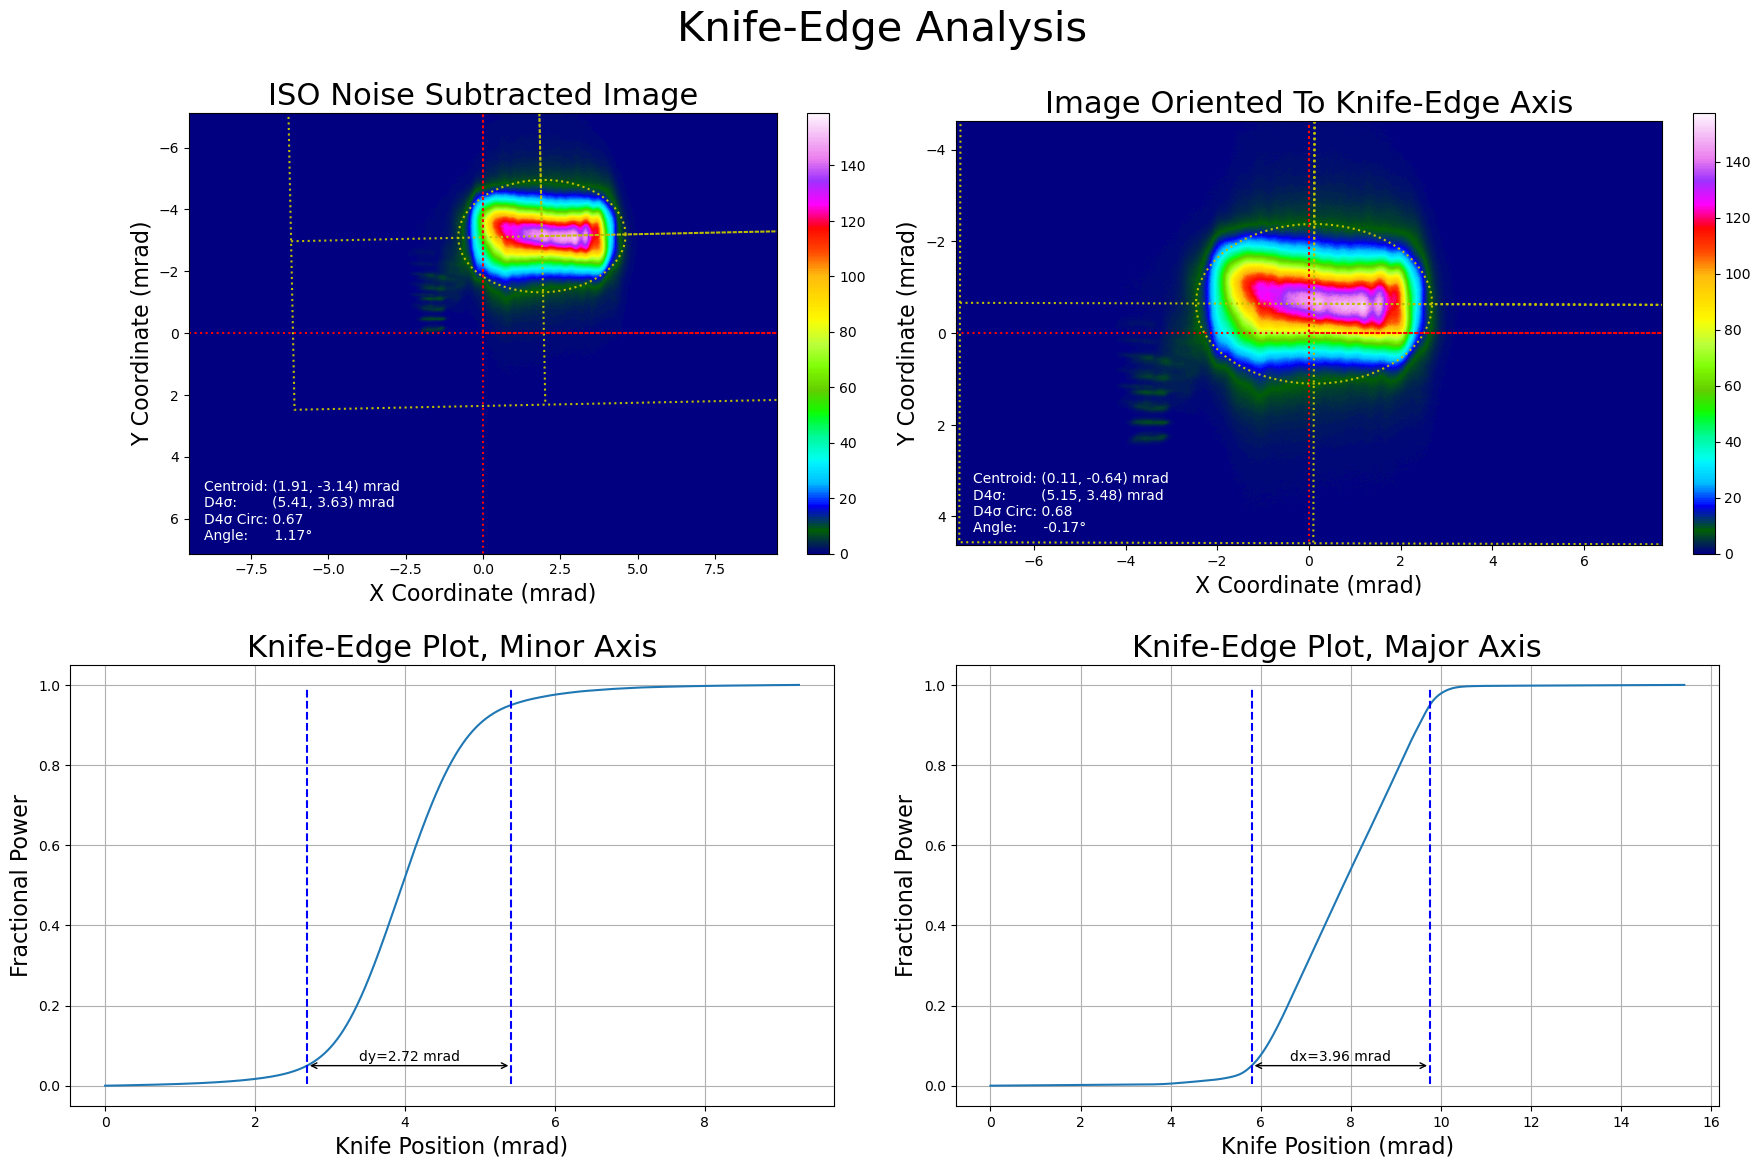

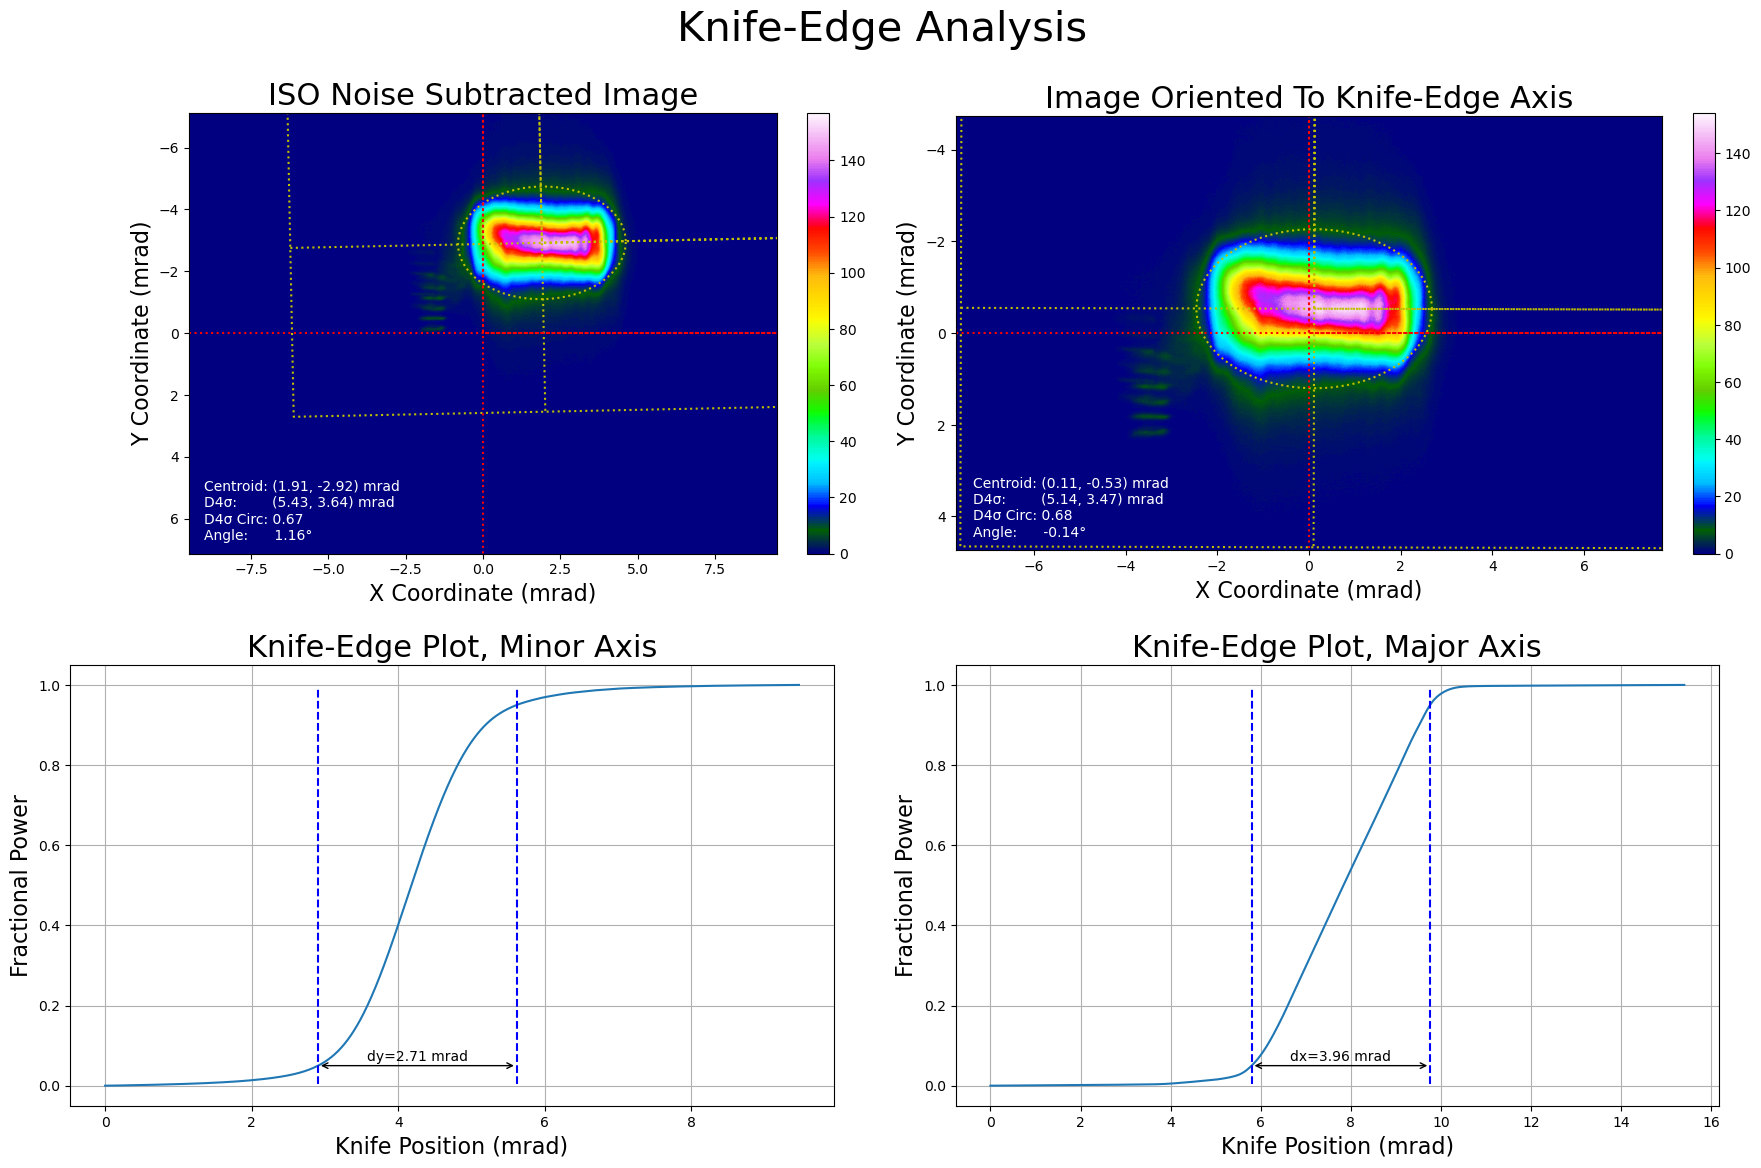

In [7]:
import sys
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Import from this directory so we can rapidly test
sys.path.append('../') # Needed for import
import laserbeamtools as lbs

img = lbs.load_img('../tests/test_beam_profiles/BES/9.bmp')
lbs.plot_knife_edge_analysis(img, pixel_size=2.2 / 300, units='mrad')

img = lbs.load_img('../tests/test_beam_profiles/BES/10.bmp')
lbs.plot_knife_edge_analysis(img, pixel_size=2.2 / 300, units='mrad')